# Web3Resear.ch-TRON: Extracting, Exploring On-chain Data and Unravelling Stablecoin-favored Ecosystem of TRON Blockchain

## Get Ready

In [2]:
import requests
from binascii import hexlify, unhexlify
import clickhouse_connect
import json
import matplotlib.pyplot as plt 
import seaborn as sns
import base58
import pandas as pd

# manually using clickhouse connect to connect W3R backend
client = clickhouse_connect.get_client()
tronscan_labels = {}

TRONSCAN_API_KEY = ""

for label in json.load(open("labels.tronscan.json")):
    tronscan_labels[label["address"]] = f"{label['name']},{label['address_tag']}"

def Taddr2Hex(taddr, evm_prefix=False):
    hex_addr = base58.b58decode_check(taddr).hex()
    assert hex_addr[:2] == "41"
    if evm_prefix:
        hex_addr = "0" * 24 + hex_addr.removeprefix("41")

    return hex_addr

def hex2Taddr(hex_addr: str):
    if hex_addr.startswith("0" * 24):
        raw_addr = unhexlify("41" + hex_addr.removeprefix("0" * 24))
    elif hex_addr.startswith("41"):
        raw_addr = unhexlify(hex_addr)
    else:
        raise Exception("invalid hex address")
    Taddr = base58.b58encode_check(raw_addr).decode()
    assert Taddr.startswith("T")
    return Taddr


print(Taddr2Hex("TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"))
assert hex2Taddr(Taddr2Hex("TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t")) == "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"

41a614f803b6fd780986a42c78ec9c7f77e6ded13c


In [3]:
# ready the contract details
q = client.query('select contractAddress, name from tron.createSmartContracts')
result = list(q.named_results())

contract_names = {}

for r in result:
    contract_addr = r["contractAddress"].decode()
    name = r['name']
    # if name == "":
    #     requests.post(
    #         url="http://127.0.0.1:8090/wallet/triggerconstantcontract", 
    #         json={
    #             "contract_address": contract_addr, 
    #             "function_selector": "name()"
    #         }).json()
    contract_names[contract_addr] = name

def get_contract_name(contract_addr):
    name = tronscan_labels.get(contract_addr, "").strip()
    if name == "" or name == "Token":
        name = contract_names.get(contract_addr, "").strip()
    if name == "" or name == "Token":
        resp = requests.get(
                url="https://apilist.tronscanapi.com/api/accountv2?address=" + contract_addr,
                headers={"TRON-PRO-API-KEY": TRONSCAN_API_KEY}
            ).json()
        name = resp.get("publicTag", "").strip()
        if name == "" or name == "Token":
            name = resp.get("name", "").strip()
        if name == "" or name == "Token":
            name = contract_addr
            print("no name found for", contract_addr)
    return name

# asset_names = {}
# q = client.query('select id, name from tron.assetIssueContracts')
# result = list(q.named_results())
# for r in result:
#     asset_names[r["id"]] = r["name"]





In [53]:
def get_asset_name(id):
    resp = requests.get(
                url="https://apilist.tronscanapi.com/api/token?showAll=1&id=" + id,
                headers={"TRON-PRO-API-KEY": TRONSCAN_API_KEY}
            ).json()
    if resp.get("data") is None or len(resp.get("data")) == 0:
        print("no data found for", id)
    name = resp.get("data")[0].get("name")
    return name

## Get all tables

In [54]:
q = client.query('show tables from tron')
tables: list[str] = [r[0] for r in q.result_rows]
tables

['accountCreateContracts',
 'accountPermissionUpdateContracts',
 'accountUpdateContracts',
 'assetIssueContracts',
 'blocks',
 'cancelAllUnfreezeV2Contracts',
 'clearAbiContracts',
 'createSmartContracts',
 'delegateResourceContracts',
 'exchangeCreateContracts',
 'exchangeInjectContracts',
 'exchangeTransactionContracts',
 'exchangeWithdrawContracts',
 'freezeBalanceContracts',
 'freezeBalanceV2Contracts',
 'internals',
 'logs',
 'marketCancelOrderContracts',
 'marketSellAssetContracts',
 'participateAssetIssueContracts',
 'shieldedTransferContracts',
 'transactions',
 'transferAssetContracts',
 'transferContracts',
 'triggerSmartContracts',
 'undelegateResourceContracts',
 'unfreezeAssetContracts',
 'unfreezeBalanceContracts',
 'unfreezeBalanceV2Contracts',
 'updateAssetContracts',
 'updateBrokerageContracts',
 'updateEnergyLimitContracts',
 'updateSettingContracts',
 'voteWitnessContracts',
 'withdrawBalanceContracts',
 'withdrawExpireUnfreezeContracts',
 'witnessUpdateContracts']

## Get latest block

In [55]:
q = client.query('SELECT max(number) as max, count(*) as cnt, max(timestamp) as timestamp from tron.blocks')
result = list(q.named_results())[0]
print(result["max"], result["cnt"], result["timestamp"])

from datetime import datetime

print(datetime.fromtimestamp(result["timestamp"] / 1000))

60505000 60505001 1712156352000
2024-04-03 22:59:12


In [56]:
q = client.query('SELECT count(*) as cnt from tron.transactions')
result = list(q.named_results())[0]
print(result["cnt"])

# q = client.query('SELECT count(*) as cnt from tron.transactions group by ')
# result = list(q.named_results())[0]
# print(result["cnt"])


8190158591


## Analysis all contract calls

In [57]:
contract_call_table_info = {}
for table in tables:
    if not table.endswith("Contracts"):
        continue

    q = client.query(f'SELECT count(*) as cnt from tron.{table}')
    result = list(q.named_results())[0]

    contract_call_table_info[table] = result["cnt"]

contract_call_tables = sorted(contract_call_table_info.items(), key=lambda x: x[1], reverse=True)
print(contract_call_tables)

[('triggerSmartContracts', 3437398059), ('transferContracts', 2934561912), ('transferAssetContracts', 1068185574), ('delegateResourceContracts', 134761200), ('undelegateResourceContracts', 132431935), ('freezeBalanceContracts', 33956579), ('accountCreateContracts', 31747589), ('unfreezeBalanceContracts', 23384479), ('voteWitnessContracts', 16256198), ('withdrawBalanceContracts', 9650347), ('exchangeTransactionContracts', 1774697), ('freezeBalanceV2Contracts', 961679), ('createSmartContracts', 738258), ('unfreezeBalanceV2Contracts', 324737), ('withdrawExpireUnfreezeContracts', 200681), ('accountPermissionUpdateContracts', 193875), ('participateAssetIssueContracts', 134540), ('accountUpdateContracts', 44911), ('cancelAllUnfreezeV2Contracts', 15347), ('assetIssueContracts', 5040), ('updateBrokerageContracts', 2010), ('updateSettingContracts', 1388), ('exchangeInjectContracts', 1320), ('witnessUpdateContracts', 760), ('exchangeWithdrawContracts', 675), ('unfreezeAssetContracts', 303), ('up

TODO: further analysis some contract calls

In [58]:
q = client.query(f'select count(distinct ownerAddress) as ownerCnt, count(distinct `type`) as typeCnt  from tron.accountCreateContracts')
result = list(q.named_results())
result

[{'ownerCnt': 7978, 'typeCnt': 3}]

enum AccountType {
  Normal = 0;
  AssetIssue = 1;
  Contract = 2;
}

In [59]:
q = client.query(f'select count(*) as cnt, count(distinct ownerAddress) as ownerCnt, `type` from tron.accountCreateContracts group by `type`')
result = list(q.named_results())
"created account types", result

('created account types',
 [{'cnt': 31747575, 'ownerCnt': 7975, 'type': 0},
  {'cnt': 11, 'ownerCnt': 3, 'type': 2},
  {'cnt': 3, 'ownerCnt': 2, 'type': 1}])

使用私钥创建的新地址无法立即获得能量和带宽等资源,需要后续通过其他方式获取,比如从交易所转入TRX并冻结。而accountCreateContract可以在创建时直接冻结TRX换取初始资源。
如果需要批量生成大量地址用于代币分发等场景,使用私钥生成地址就比较低效,需要反复操作,而accountCreateContract可以更方便地完成此任务。
私钥生成的地址权限模型相对简单,而accountCreateContract可以在创建时预先设置owner和witness等高级权限模型。

可以看出，大部分（几乎所有）都是Normal Account

In [60]:
q = client.query(f'select count(*) as cnt from tron.accountCreateContracts group by ownerAddress')
result = list(q.result_rows)
result = [r[0] for r in result]

"max", max(result), "min", min(result), "avg", sum(result) / len(result)

('max', 2853848, 'min', 1, 'avg', 3979.3919528703937)

In [61]:
q = client.query(f'select count(*) as cnt, ownerAddress from tron.accountCreateContracts group by ownerAddress order by cnt desc limit 10')
result = list(q.named_results())

for r in result:
    address = r["ownerAddress"].decode("utf-8")
    tag = tronscan_labels.get(address, "")
    print(r["cnt"], address, tag)


2853848 TA1EHWb1PymZ1qpBNfNj9uTaxd18ubrC7a 
1529931 TXj3Zjdd7kAWLUHKZCD3XpJSpVqWxPGPtA 
1334214 TWaSm8dnvTdJQ9hcpW3g8m4QEfJspcuDwA ,Btt speed hot wallet
1320541 TBREsCfBdPyD612xZnwvGPux7osbXvtzLh 
848174 TD3qKTHzqN37N3gsPciaZRQQnHCWxdDDdD 
787629 TLeR8qjtYzcALwr1KWXeN49g1HeBNbfytm 
644924 TR3Y5cYicN7beNMCvgMhx2BNYYgGqid4MY 
501793 TRZVM8fofhRSiiNgCj3bWfXmDpmnBKXmjD 
478047 TBPjNtRwuNgmz4Ek98PzACVUbxVndmWXab 
459652 TT2QPCdQEqt7WVA5U1pvT1BzpZU9pXTh9T 


= =不太清楚这地址，略吧

### accountPermissionUpdateContracts

In [62]:
q = client.query(f'select count(*) as cnt, ownerAddress from tron.accountPermissionUpdateContracts group by ownerAddress order by cnt desc limit 10')
result = list(q.named_results())

# print(result)
for r in result:
    address = r["ownerAddress"].decode("utf-8")
    tag = tronscan_labels.get(address, "")
    print(r["cnt"], address, tag)

409 TH7RtRKXP1t7yzuTK2Ch93KpdhmthZw2DC 
210 TReWn36nviKgeXRzPHs46okjuhyBz3L1B2 
201 THrD5ajARV4wRMFTHFspzNVrPFVTb4LpEK 
170 TK47SmuLZpvYLpgGGXKzzBUH1SsHY49ys7 
122 TPoierfUmTmfAqADWJr2PBEfRGW8vCddWB 
101 TJJW8P8h9sDa1wPLt4x6Pq72H2Rp9wQWEA 
92 TN1DWay6C2TahkZHuZ6muuRvw6wHC9tyJw 
87 TFZMKVpDu7XanKUYtd1FpPtLUqkgcGC7hg 
82 TWk1UT8j5T4yBaX88nre8DxjGGyPnkEbxv 
76 TLCWx7bmtPG7P77mqeFnv2oJfQmWr8Fexn 


193875 items

在TRON网络中,owner和witness等高级权限模型主要用于实现账户权限的分离和控制,提升账户安全性和灵活性。它们的作用如下:

owner权限:


owner权限是账户的最高管理权限,拥有对账户所有资源和权限的完全控制能力。
通常owner权限由账户所有者自己持有,是最核心的权限,需要格外小心保管。
owner可以执行如下操作:更新自身权限、账户解冻、转移记录、发行通证、部署合约等高风险操作。


witness权限:


witness相当于账户的"看守者"权限,可以对账户的交易等日常操作进行监控。
witness无法执行高风险操作,但可以收集交易所需签名,提升安全性。
通常witness权限可以分散持有,作为对owner权限的制衡。


active权限:


active权限用于日常的转账、合约调用等操作。
拥有active权限即可进行正常的区块链交互。

通过owner、witness和active三种不同的权限模型,TRON网络允许用户对账户权限进行精细化的分离和控制,从而提高账户资金和操作的安全性。尤其对于机构、交易所、项目方等有特殊安全需求的账户,高级权限模型可以发挥重要作用。

### accountUpdateContracts

### blocks

```sql
select count(distinct witnessId), count(distinct witnessAddress) from tron.blocks

select count(*), witnessId from tron.blocks group by witnessId
select count(*), witnessAddress from tron.blocks group by witnessAddress
select max(transactionCount), min(transactionCount) from tron.blocks

```
TODO: guess how many 0-tx blocks?

In [63]:
q = client.query(f'select count(distinct witnessId) as witnessIdCnt, count(distinct witnessAddress) as witnessAddressCnt from tron.blocks')
result = list(q.named_results())
print(result)

[{'witnessIdCnt': 1, 'witnessAddressCnt': 113}]


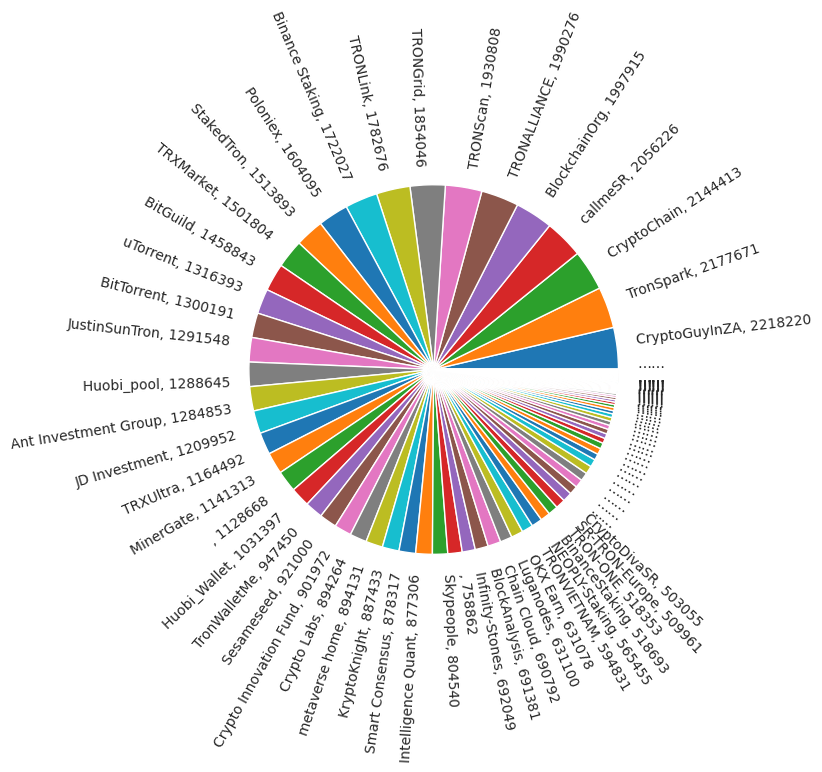

In [64]:
q = client.query(f'select witnessAddress, count(*) as cnt from tron.blocks group by witnessAddress order by cnt desc')
result = list(q.named_results())
# print(result)
data = []
labels = []
for r in result:
    address = r["witnessAddress"].decode("utf-8")
    tag = tronscan_labels.get(address, "")
    data.append(r["cnt"])
    if r["cnt"] > 500000:
        labels.append(f"{tag} {r['cnt']}")
    else:
        labels.append("……")
    # print(r["cnt"], address, tag)

sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6)) # Set figure size
plt.pie(data, labels=labels, rotatelabels=True) # Create pie chart
plt.show() # Show chart

In [65]:
q = client.query(f'select blockNum as block_number, count(*) as transaction_count from tron.transactions group by blockNum order by blockNum')
result = list(q.named_results())
# print(result)
# x = []
# y = []


In [66]:
from datetime import datetime

def bn2ts(block_number):
    return 1530374319 + block_number * 3

records = []
today = datetime.fromtimestamp(bn2ts(result[0]["block_number"]))
counter = 0
for r in result:
    date = datetime.fromtimestamp(bn2ts(r["block_number"]))
    if today.day == date.day:
        # sum up the transaction count
        counter += r["transaction_count"]
    else:
        records.append({"date": today.date(), "transaction_count": counter})
        today = date
        counter = r["transaction_count"]
    # x.append(r["blockNum"])
    # y.append(r["cnt"])
records.append({"date": today.date(), "transaction_count": counter})

data = pd.DataFrame.from_records(records)
data

date  transaction_count
0     2018-06-30                  3
1     2018-07-01               3108
2     2018-07-02               2123
3     2018-07-03               2003
4     2018-07-04               2286
...          ...                ...
2097  2024-03-27            4787496
2098  2024-03-28            4766904
2099  2024-03-29            5444494
2100  2024-03-30            5573847
2101  2024-03-31            4583712

[2102 rows x 2 columns]

<Axes: xlabel='date', ylabel='transaction_count'>

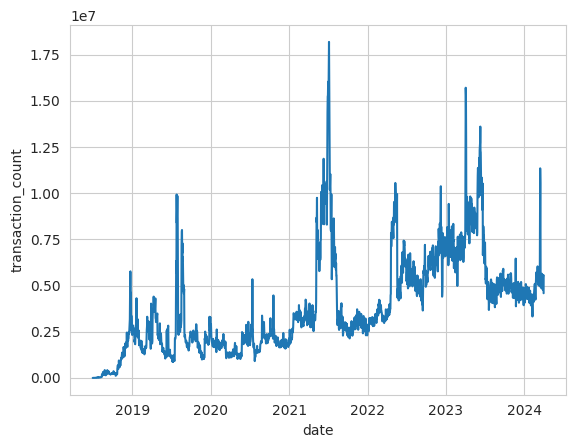

In [67]:
sns.lineplot(data, x="date", y="transaction_count")

In [68]:
q = client.query(f'select count(*) as cnt, blockNum from tron.transactions group by blockNum having cnt = 0 order by blockNum')
result = list(q.named_results())
print(len(result))

0


## transferContracts and transferAssetContracts

In [69]:
q = client.query(f'select count(*) as cnt, ownerAddress from tron.transferContracts group by ownerAddress order by cnt desc limit 50')
result = list(q.named_results())
print(result)


[{'cnt': 31435603, 'ownerAddress': b'TBREsCfBdPyD612xZnwvGPux7osbXvtzLh'}, {'cnt': 14605298, 'ownerAddress': b'TB3UZsVL7SdrrugRfeyXK5C75e7V3CDyty'}, {'cnt': 11925604, 'ownerAddress': b'TYD4pB7wGi1p8zK67rBTV3KdfEb9nvNDXh'}, {'cnt': 9246213, 'ownerAddress': b'TCSN2TXGLi3KnLTtMY2ch3Hh8jwUtotkYF'}, {'cnt': 9186513, 'ownerAddress': b'TAUN6FwrnwwmaEqYcckffC7wYmbaS6cBiX'}, {'cnt': 8480389, 'ownerAddress': b'THzz3LVkmELyWzAtrfi1JPZ3oUyFt4w7DF'}, {'cnt': 8458601, 'ownerAddress': b'TDgZ9FBLbM7LDW7inPVrWUktAZ2ruqDYYe'}, {'cnt': 8319088, 'ownerAddress': b'T9yssSMcwoSXkh4jVpXG8KPPzeAyA5WQk6'}, {'cnt': 7435727, 'ownerAddress': b'TK4jwnvhjm63ChLFa2HjhYqrroninzGoK4'}, {'cnt': 6761906, 'ownerAddress': b'TEPSrSYPDSQ7yXpMFPq91Fb1QEWpMkRGfn'}, {'cnt': 6344977, 'ownerAddress': b'TWDDUF6JxKgC8ErsprDQtf5znhJUYtF43N'}, {'cnt': 6215413, 'ownerAddress': b'TTcYhypP8m4phDhN6oRexz2174zAerjEWP'}, {'cnt': 6204604, 'ownerAddress': b'TBA6CypYJizwA9XdC7Ubgc5F1bxrQ7SqPt'}, {'cnt': 5447287, 'ownerAddress': b'TAQ3S3o1LnHG

In [70]:
others = 0
data = []
labels = []
for i, r in enumerate(result):
    print(i, r["cnt"], r["ownerAddress"])
    address = r["ownerAddress"].decode("utf-8")
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(address)} {r['cnt']}")


0 31435603 b'TBREsCfBdPyD612xZnwvGPux7osbXvtzLh'
no name found for TBREsCfBdPyD612xZnwvGPux7osbXvtzLh
1 14605298 b'TB3UZsVL7SdrrugRfeyXK5C75e7V3CDyty'
no name found for TB3UZsVL7SdrrugRfeyXK5C75e7V3CDyty
2 11925604 b'TYD4pB7wGi1p8zK67rBTV3KdfEb9nvNDXh'
no name found for TYD4pB7wGi1p8zK67rBTV3KdfEb9nvNDXh
3 9246213 b'TCSN2TXGLi3KnLTtMY2ch3Hh8jwUtotkYF'
no name found for TCSN2TXGLi3KnLTtMY2ch3Hh8jwUtotkYF
4 9186513 b'TAUN6FwrnwwmaEqYcckffC7wYmbaS6cBiX'
5 8480389 b'THzz3LVkmELyWzAtrfi1JPZ3oUyFt4w7DF'
no name found for THzz3LVkmELyWzAtrfi1JPZ3oUyFt4w7DF
6 8458601 b'TDgZ9FBLbM7LDW7inPVrWUktAZ2ruqDYYe'
no name found for TDgZ9FBLbM7LDW7inPVrWUktAZ2ruqDYYe
7 8319088 b'T9yssSMcwoSXkh4jVpXG8KPPzeAyA5WQk6'
no name found for T9yssSMcwoSXkh4jVpXG8KPPzeAyA5WQk6
8 7435727 b'TK4jwnvhjm63ChLFa2HjhYqrroninzGoK4'
no name found for TK4jwnvhjm63ChLFa2HjhYqrroninzGoK4
9 6761906 b'TEPSrSYPDSQ7yXpMFPq91Fb1QEWpMkRGfn'
10 6344977 b'TWDDUF6JxKgC8ErsprDQtf5znhJUYtF43N'
no name found for TWDDUF6JxKgC8ErsprDQtf5znh

<BarContainer object of 50 artists>

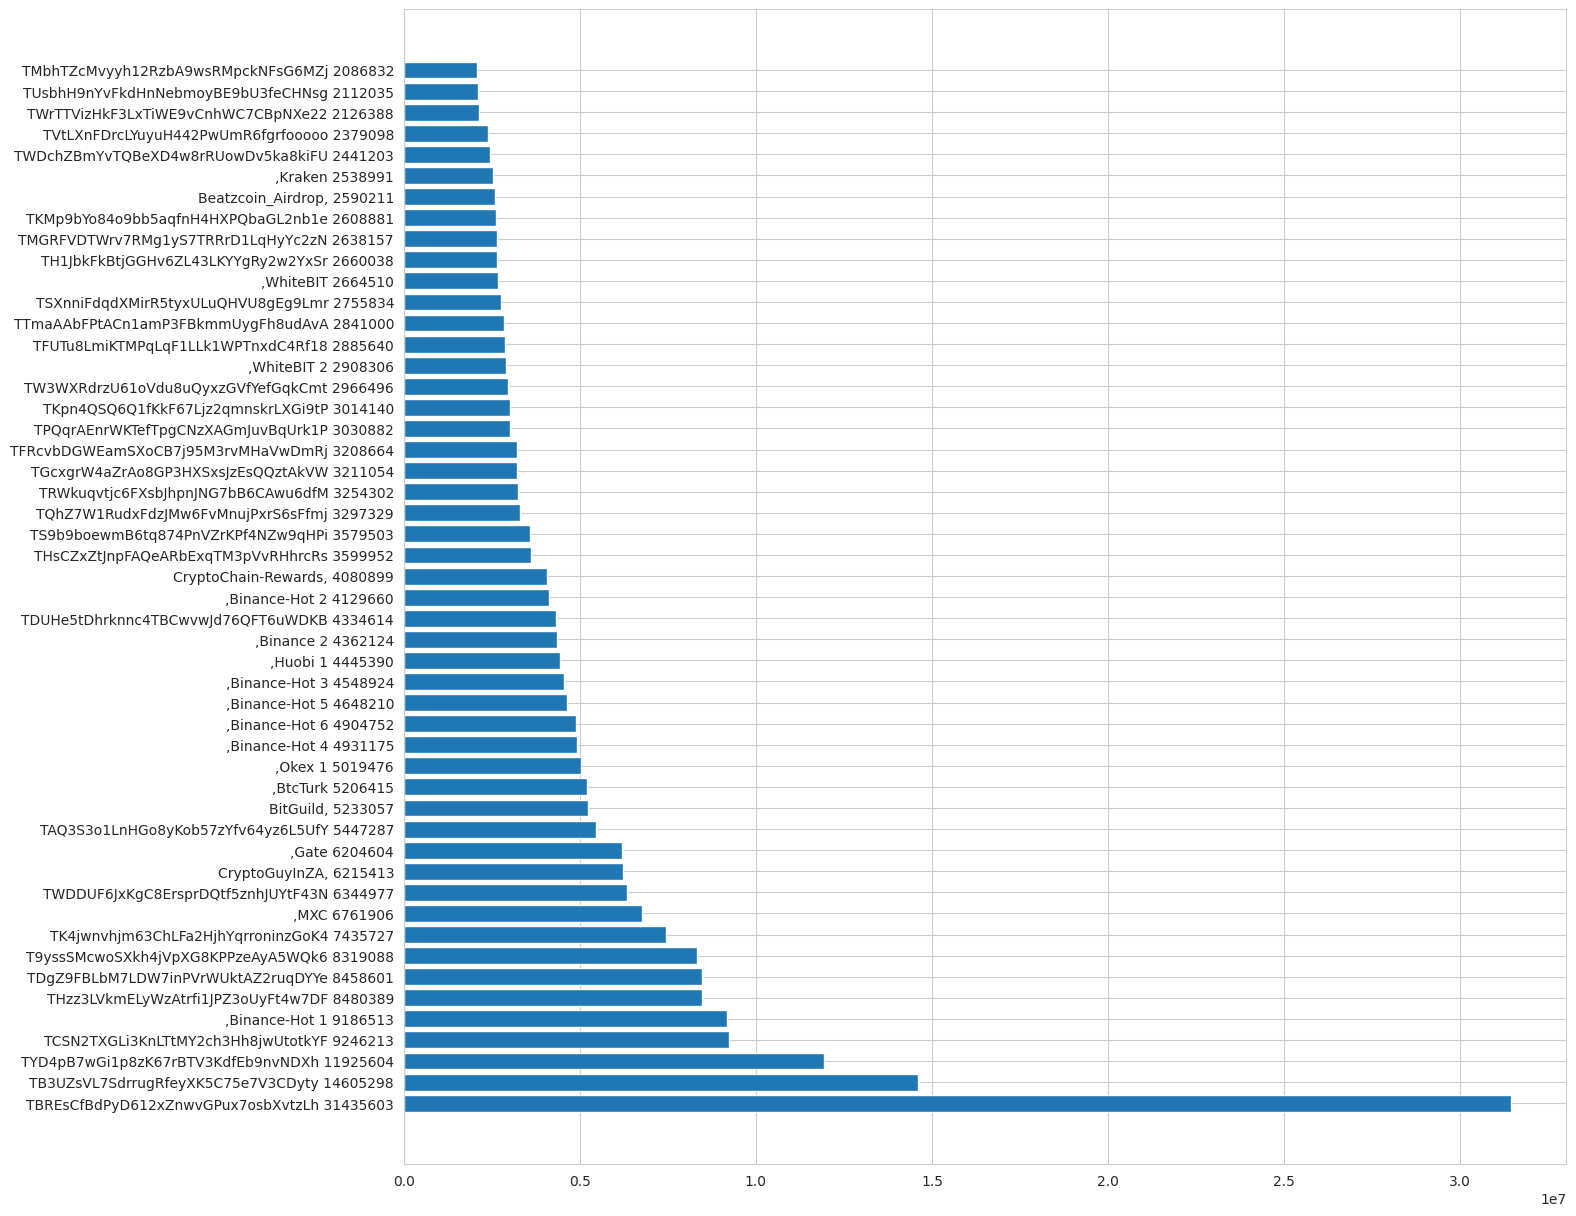

In [71]:
plt.figure(figsize=(15,15)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

In [72]:
q = client.query(f'select sum(amount) as amount, ownerAddress from tron.transferContracts group by ownerAddress order by amount desc limit 50')
result = list(q.named_results())
print(len(result))

50


In [73]:
others = 0
data = []
labels = []
for i, r in enumerate(result):
    address = r["ownerAddress"].decode("utf-8")
    data.append(r["amount"])
    labels.append(f"{get_contract_name(address)}")

no name found for TAN4JXnGSYwZwmShVy5yaVAedn8YTeARVd
no name found for TSnjgPDQfuxx72iaPy82v3T8HrsN4GVJzW
no name found for TLnQABU24kRyXKiCDDHbfmsz14fQLTjfqz
no name found for TV6qo5vZ9t118WfkqqhFPLTRMxgPRXVr7t
no name found for TXrauXw2wazRPZd2Q5tSYRnFveCyeaCign
no name found for TKTWiCfNyitRiA31eiMLTTFYah6m2aLkup
no name found for TWzMV62eycoJWFRfpmJoUdc4oUhtK6TvGV
no name found for TRWkuqvtjc6FXsbJhpnJNG7bB6CAwu6dfM
no name found for TJkgTCg91dEfsT9to74VDXi7uUxRDqF2ft
no name found for TKpn4QSQ6Q1fKkF67Ljz2qmnskrLXGi9tP
no name found for TCP5CkoAaEEwYYTtrJzstN1Ny2oRULM692
no name found for TFVSdAtj1XzGDqpQupivhKKatZg1C6HJeq
no name found for TDtt6SwfFuHo7ZBGhHKX9buuJvkfk9roPH
no name found for TRJEUBkcDYTBUtfVtQJu3kGNEPFJv7umt2
no name found for TRQE3483UWRMge6L6BsrzpgmDfdxHo6rxX
no name found for TDqMwZVTSPLTCZQC55Db3J69eXY7HLCmfs
no name found for TXTY5SuNrCpasvDxoqWe8VNnRsKvwf8B2H
no name found for TQ1tKTUUuoxZdzp4Vaa6eD7CVaMfhP2Jmp
no name found for TXQLsiDL9yqC6BPKvMxCzaMaaxrr

<BarContainer object of 50 artists>

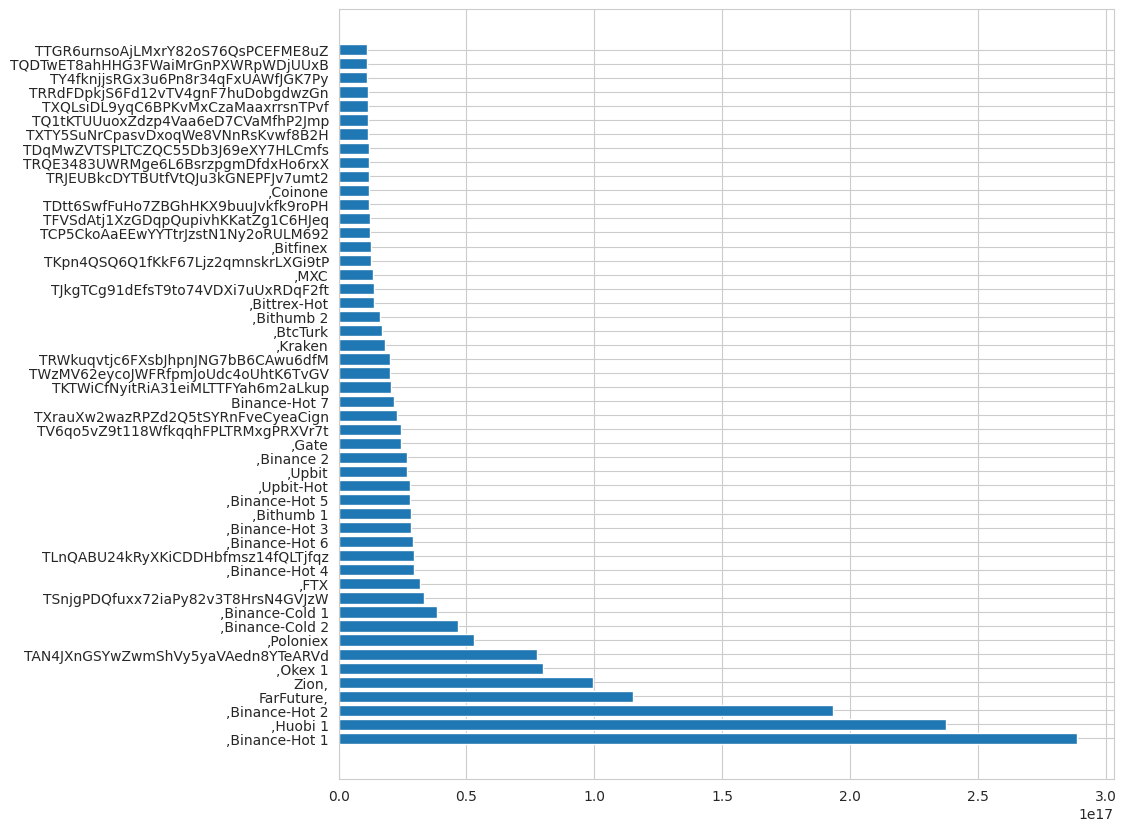

In [74]:
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

[{'cnt': 8686783, 'toAddress': b'TNaRAoLUyYEV2uF7GUrzSjRQTU8v5ZJ5VR'}, {'cnt': 8367862, 'toAddress': b'TV6MuMXfmLbBqPZvBHdwFsDnQeVfnmiuSi'}, {'cnt': 7863604, 'toAddress': b'TXnQHq7647qmtbNXHjBdh8GRkQULZ1XYuk'}, {'cnt': 7785628, 'toAddress': b'TBA6CypYJizwA9XdC7Ubgc5F1bxrQ7SqPt'}, {'cnt': 7528214, 'toAddress': b'TKpn4QSQ6Q1fKkF67Ljz2qmnskrLXGi9tP'}, {'cnt': 7062230, 'toAddress': b'TAUN6FwrnwwmaEqYcckffC7wYmbaS6cBiX'}, {'cnt': 4865056, 'toAddress': b'TVmQM7BP7GdMHKY9hUEBjttCTJSaDHN888'}, {'cnt': 4502771, 'toAddress': b'TFUTu8LmiKTMPqLqF1LLk1WPTnxdC4Rf18'}, {'cnt': 4480483, 'toAddress': b'TGR3xRu48ttYsR8veXBACWTJHWUb4B8888'}, {'cnt': 4301732, 'toAddress': b'TUN4dKBLbAZjArUS7zYewHwCYA6GSUeSaK'}, {'cnt': 4020112, 'toAddress': b'TAa47voWQuXfDTJvMEiV9G7ykv8jbYrGZa'}, {'cnt': 4013421, 'toAddress': b'T9yssSMcwoSXkh4jVpXG8KPPzeAyA5WQk6'}, {'cnt': 3996530, 'toAddress': b'TU4vEruvZwLLkSfV9bNw12EJTPvNr7Pvaa'}, {'cnt': 3958341, 'toAddress': b'TM1zzNDZD2DPASbKcgdVoTYhfmYgtfwx9R'}, {'cnt': 3734193, 't

<BarContainer object of 50 artists>

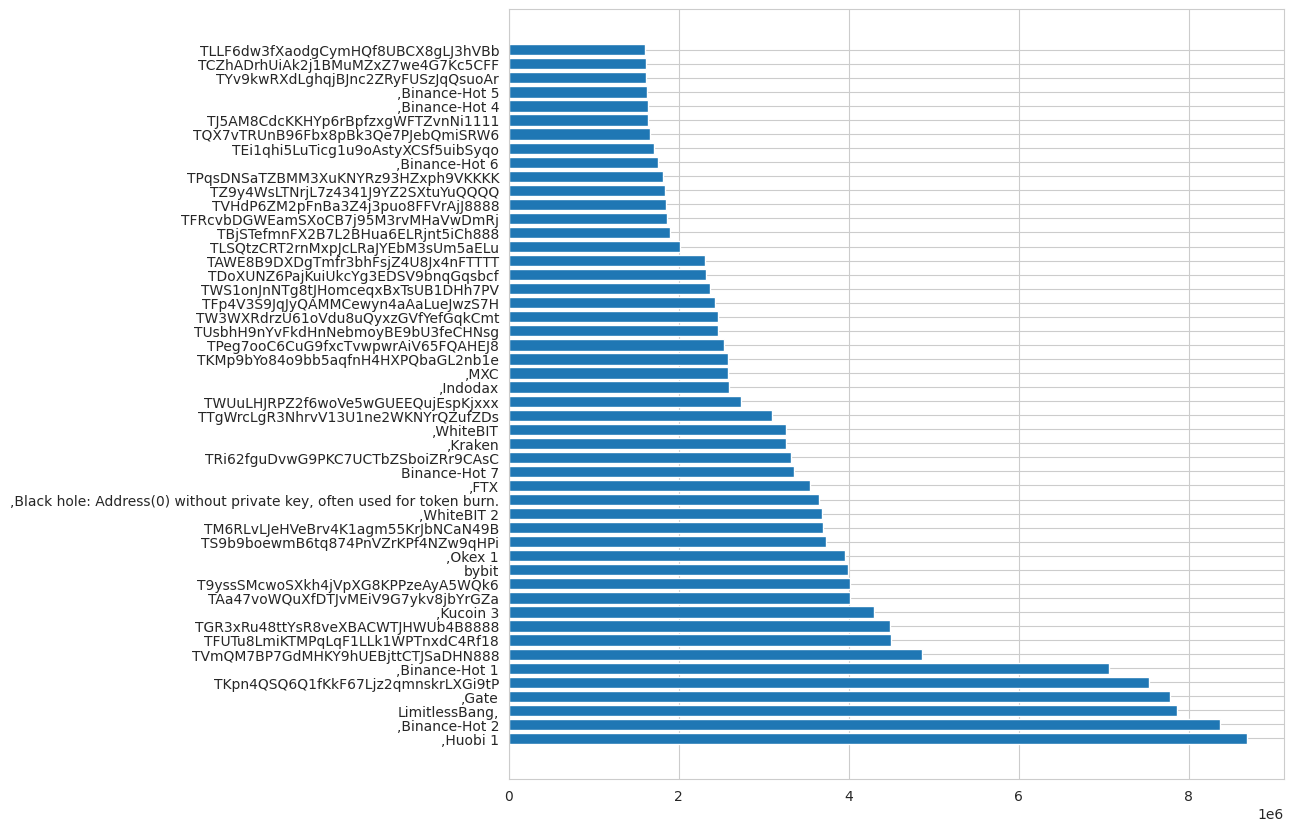

In [75]:
q = client.query(f'select count(*) as cnt, toAddress from tron.transferContracts group by toAddress order by cnt desc limit 50')
result = list(q.named_results())
print(result)

others = 0
data = []
labels = []
for i, r in enumerate(result):
    print(i, r["cnt"], r["toAddress"])
    address = r["toAddress"].decode("utf-8")
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(address)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

[{'amount': 288424567796847296, 'toAddress': b'TAUN6FwrnwwmaEqYcckffC7wYmbaS6cBiX'}, {'amount': 237739251884572264, 'toAddress': b'TNaRAoLUyYEV2uF7GUrzSjRQTU8v5ZJ5VR'}, {'amount': 194997865705100147, 'toAddress': b'TV6MuMXfmLbBqPZvBHdwFsDnQeVfnmiuSi'}, {'amount': 107084368060465035, 'toAddress': b'TQooBX9o8iSSprLWW96YShBogx7Uwisuim'}, {'amount': 99000001536260497, 'toAddress': b'TLLM21wteSPs4hKjbxgmH1L6poyMjeTbHm'}, {'amount': 80510197998531698, 'toAddress': b'TM1zzNDZD2DPASbKcgdVoTYhfmYgtfwx9R'}, {'amount': 77504754793937707, 'toAddress': b'TAN4JXnGSYwZwmShVy5yaVAedn8YTeARVd'}, {'amount': 51962886926258209, 'toAddress': b'TNCmcTdyrYKMtmE1KU2itzeCX76jGm5Not'}, {'amount': 46234963760796257, 'toAddress': b'TWd4WrZ9wn84f5x1hZhL4DHvk738ns5jwb'}, {'amount': 35016840175497354, 'toAddress': b'TMuA6YqfCeX8EhbfYEg5y7S4DqzSJireY9'}, {'amount': 33251807524000000, 'toAddress': b'TSnjgPDQfuxx72iaPy82v3T8HrsN4GVJzW'}, {'amount': 31485505774322786, 'toAddress': b'TYDzsYUEpvnYmQk4zGP9sWWcTEd2MiAtW6'},

<BarContainer object of 50 artists>

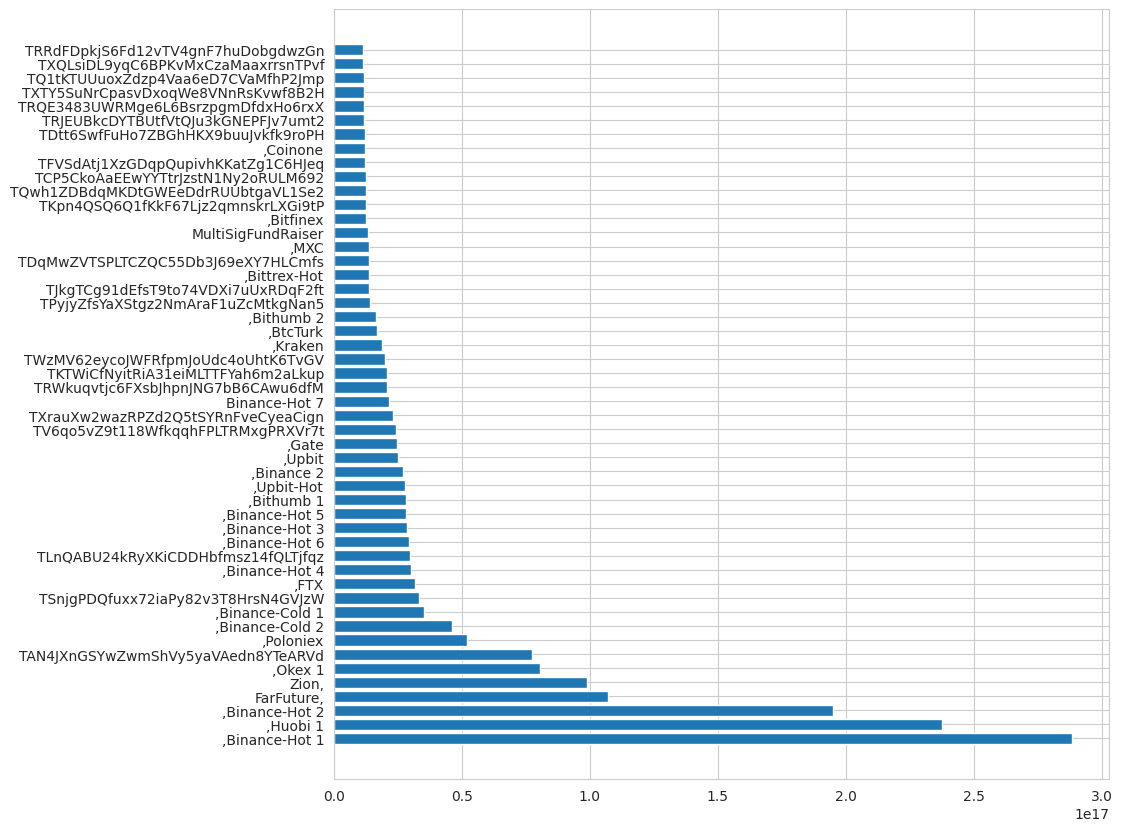

In [76]:
q = client.query(f'select sum(amount) as amount, toAddress from tron.transferContracts group by toAddress order by amount desc limit 50')
result = list(q.named_results())
print(result)

others = 0
data = []
labels = []
for i, r in enumerate(result):
    print(i, r["amount"], r["toAddress"])
    address = r["toAddress"].decode("utf-8")
    data.append(r["amount"])
    labels.append(f"{get_contract_name(address)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

In [77]:
q = client.query(f'select count(*) as cnt, assetName from tron.transferAssetContracts group by assetName order by cnt desc limit 50')
result = list(q.named_results())
print(result)

[{'cnt': 105654584, 'assetName': '1004031'}, {'cnt': 94993460, 'assetName': '1003533'}, {'cnt': 71275298, 'assetName': '1002000'}, {'cnt': 32383259, 'assetName': '1004295'}, {'cnt': 22298585, 'assetName': '1004917'}, {'cnt': 21910952, 'assetName': '1001611'}, {'cnt': 21845519, 'assetName': '1003134'}, {'cnt': 21538514, 'assetName': '1004910'}, {'cnt': 21161748, 'assetName': '1004920'}, {'cnt': 18803142, 'assetName': '1000985'}, {'cnt': 15449990, 'assetName': '1004907'}, {'cnt': 14712283, 'assetName': '1004935'}, {'cnt': 13972231, 'assetName': '1003406'}, {'cnt': 13971796, 'assetName': '1004937'}, {'cnt': 13723599, 'assetName': '1004990'}, {'cnt': 12330720, 'assetName': '1003475'}, {'cnt': 11149850, 'assetName': '1004106'}, {'cnt': 10866807, 'assetName': '1004950'}, {'cnt': 10560130, 'assetName': '1004880'}, {'cnt': 10059579, 'assetName': '1004708'}, {'cnt': 9723088, 'assetName': '1004952'}, {'cnt': 9691854, 'assetName': '1004748'}, {'cnt': 9104555, 'assetName': '1000322'}, {'cnt': 9026

In [78]:
others = 0
data = []
labels = []
for i, r in enumerate(result):
    name = r["assetName"]
    data.append(r["cnt"])
    labels.append(f"{get_asset_name(name)}")

<BarContainer object of 50 artists>

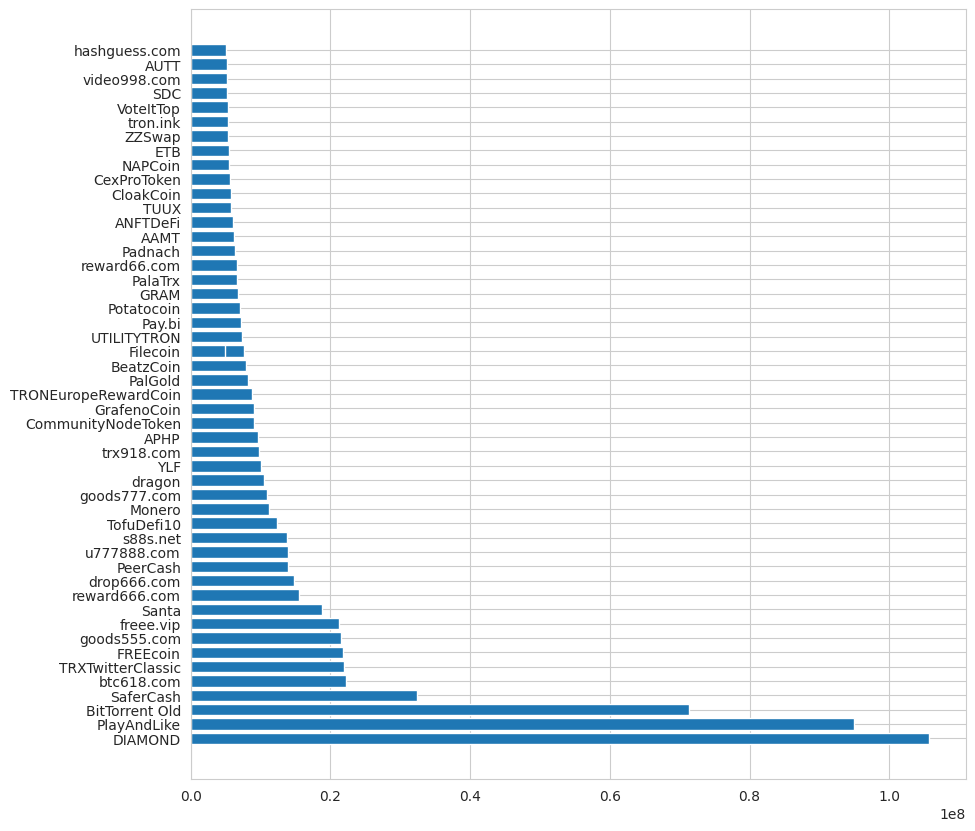

In [79]:
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

In [80]:
q = client.query(f'select sum(amount) as amount, assetName from tron.transferAssetContracts group by assetName order by amount desc limit 50')
result = list(q.named_results())
print(result)


[{'amount': 9000000328269301905, 'assetName': '1003788'}, {'amount': 9000000000010000000, 'assetName': '1004948'}, {'amount': 8649873198964294504, 'assetName': '1004031'}, {'amount': 8232501703648554353, 'assetName': '1004937'}, {'amount': 8088888888888000000, 'assetName': '1005024'}, {'amount': 7769808000000000000, 'assetName': '1003972'}, {'amount': 7295600867633108641, 'assetName': '1004172'}, {'amount': 7186250753338032249, 'assetName': '1004212'}, {'amount': 6999999999492951786, 'assetName': '1003396'}, {'amount': 5612009999800000000, 'assetName': '1004168'}, {'amount': 5003800015250814269, 'assetName': '1003211'}, {'amount': 5000181395001009831, 'assetName': '1004965'}, {'amount': 4242368208330763132, 'assetName': '1004944'}, {'amount': 4074551301996188544, 'assetName': '1004746'}, {'amount': 4004019844685000000, 'assetName': '1004245'}, {'amount': 4000200020000000000, 'assetName': '1003409'}, {'amount': 3999600002011996284, 'assetName': '1004777'}, {'amount': 3960000002000000000

In [81]:
others = 0
data = []
labels = []
for i, r in enumerate(result):
    name = r["assetName"]
    data.append(r["amount"])
    labels.append(f"{get_asset_name(name)}")

<BarContainer object of 50 artists>

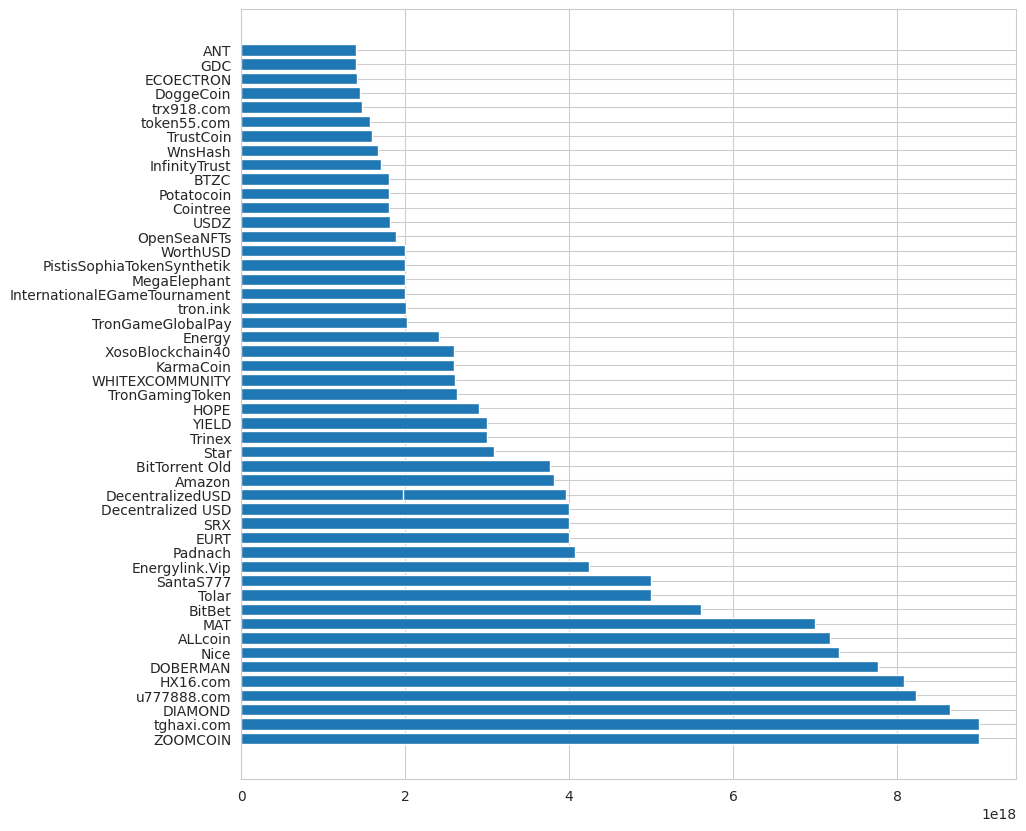

In [82]:
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

## delegateResourceContracts
BANDWIDTH:代表带宽资源。TRON网络中,每个账户都需要消耗一定的带宽资源来发送交易。
ENERGY:代表能量资源。在TRON网络中,发起智能合约操作需要消耗一定的能量。

0 - BANDWIDTH
这表示委托或撤销的资源类型是带宽资源。

1 - ENERGY
这表示委托或撤销的资源类型是能量资源。

In [83]:
q = client.query(f'select count(*) as cnt, resource from tron.delegateResourceContracts group by resource order by cnt desc')
result = list(q.named_results())
print(result)

[{'cnt': 131901114, 'resource': 1}, {'cnt': 2860086, 'resource': 0}]


[{'cnt': 10638281, 'ownerAddress': b'TWKyE8Qy9h9upx5NNgyJQtMkiX6s7ZDesT'}, {'cnt': 7742823, 'ownerAddress': b'TFw9iGzsPqMpasi7PXs9jszAvvcJ2xc73k'}, {'cnt': 6873011, 'ownerAddress': b'TL5MjX12CPXMm21tesALMeBCGni5wbc3f4'}, {'cnt': 5992126, 'ownerAddress': b'TNPdqto8HiuMzoG7Vv9wyyYhWzCojLeHAF'}, {'cnt': 5492974, 'ownerAddress': b'TK5cziq1fccjhtoX6qTG5RjC3Dtfe2wZ7f'}, {'cnt': 2676705, 'ownerAddress': b'TJGv1jeHA8QxZ5jjwY8wc4PQ2GHg4772L8'}, {'cnt': 2641932, 'ownerAddress': b'TH5NwmTNex8NaJ6SWsFicUCT35k8URmsVC'}, {'cnt': 2374710, 'ownerAddress': b'TDtdciX5J8EGSatq9WiTCgWNiFYAJihGgV'}, {'cnt': 2175940, 'ownerAddress': b'TLS9ef5ZZKX1a2pMAtaB8jRysDkAiGWR6z'}, {'cnt': 1908669, 'ownerAddress': b'TB4pdxkEGndTwyRi62Kpk9WVUecwU7czFo'}, {'cnt': 1746380, 'ownerAddress': b'TVt7oQuLnHZz252eaDFLbh66zHDGgksoSY'}, {'cnt': 1733730, 'ownerAddress': b'TT5iK8oqGEyRKJAnRwrLSZ4fM5y77F2LNT'}, {'cnt': 1507590, 'ownerAddress': b'TD3qKTHzqN37N3gsPciaZRQQnHCWxdDDdD'}, {'cnt': 1461595, 'ownerAddress': b'TXQzWHsCShXT74

<BarContainer object of 50 artists>

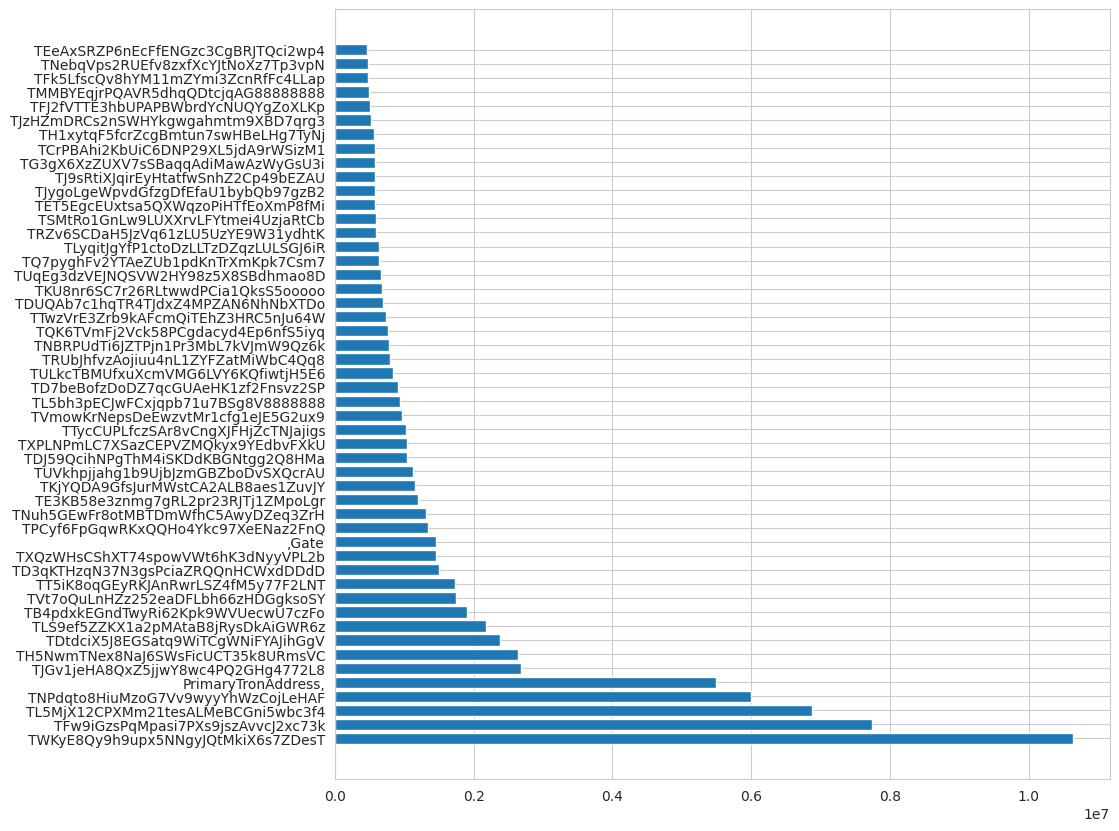

In [84]:
q = client.query(f'select count(*) as cnt, ownerAddress from tron.delegateResourceContracts where resource = 1 group by ownerAddress order by cnt desc limit 50')
result = list(q.named_results())
print(result)

others = 0
data = []
labels = []
for i, r in enumerate(result):
    name = r["ownerAddress"].decode()
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(name)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

[{'amount': 52406511235104254, 'ownerAddress': b'TWKyE8Qy9h9upx5NNgyJQtMkiX6s7ZDesT'}, {'amount': 52201476198000000, 'ownerAddress': b'TPCyf6FpGqwRKxQQHo4Ykc97XeENaz2FnQ'}, {'amount': 30392090310845200, 'ownerAddress': b'TFw9iGzsPqMpasi7PXs9jszAvvcJ2xc73k'}, {'amount': 25501186504653248, 'ownerAddress': b'TNPdqto8HiuMzoG7Vv9wyyYhWzCojLeHAF'}, {'amount': 22027959803000000, 'ownerAddress': b'TH5NwmTNex8NaJ6SWsFicUCT35k8URmsVC'}, {'amount': 20392699259000000, 'ownerAddress': b'TL5MjX12CPXMm21tesALMeBCGni5wbc3f4'}, {'amount': 13566917598000000, 'ownerAddress': b'TD2RET3SgN1G2di5jQ4QMnCK3333333333'}, {'amount': 13429740926529727, 'ownerAddress': b'TB4pdxkEGndTwyRi62Kpk9WVUecwU7czFo'}, {'amount': 10864347696000000, 'ownerAddress': b'TK5cziq1fccjhtoX6qTG5RjC3Dtfe2wZ7f'}, {'amount': 10780983882670164, 'ownerAddress': b'TEeAxSRZP6nEcFfENGzc3CgBRJTQci2wp4'}, {'amount': 9418185171714829, 'ownerAddress': b'TVt7oQuLnHZz252eaDFLbh66zHDGgksoSY'}, {'amount': 6394210015473801, 'ownerAddress': b'TDtdciX

<BarContainer object of 50 artists>

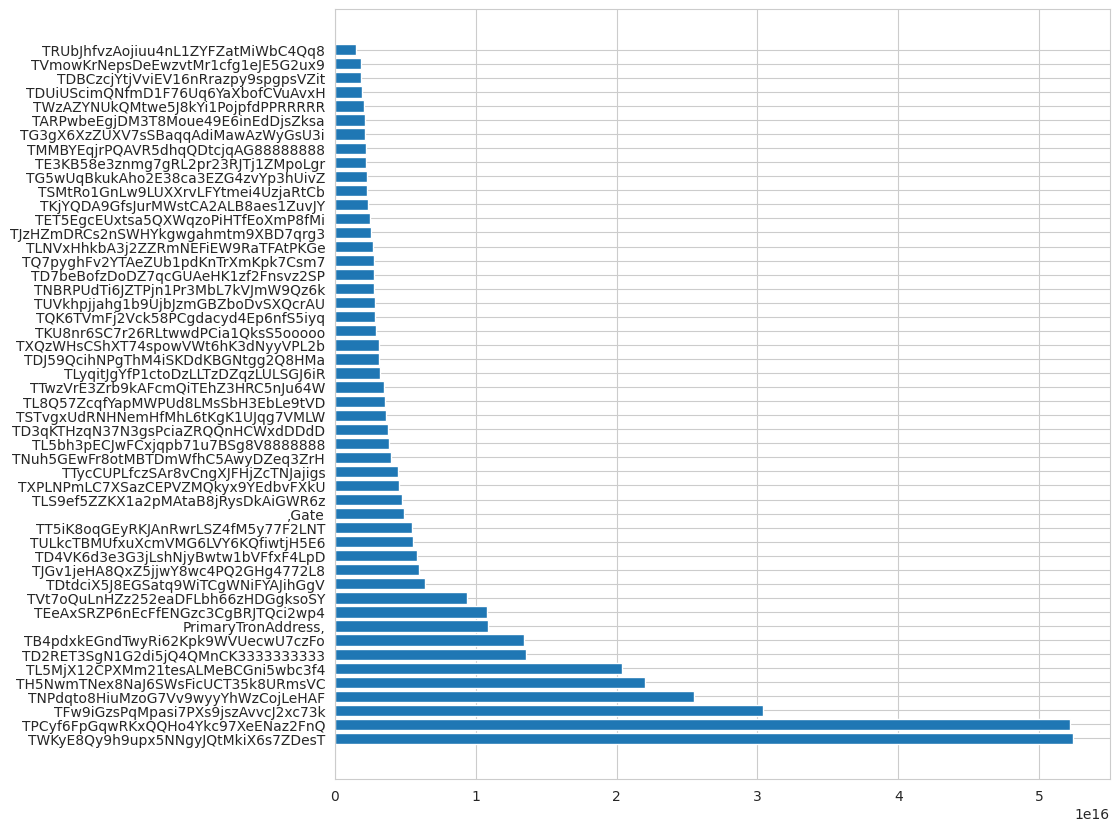

In [85]:
q = client.query(f'select sum(balance) as amount, ownerAddress from tron.delegateResourceContracts where resource = 1 group by ownerAddress order by amount desc limit 50')
result = list(q.named_results())
print(result)

others = 0
data = []
labels = []
for i, r in enumerate(result):
    name = r["ownerAddress"].decode()
    data.append(r["amount"])
    labels.append(f"{get_contract_name(name)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

[{'cnt': 714205, 'ownerAddress': b'TNPdqto8HiuMzoG7Vv9wyyYhWzCojLeHAF'}, {'cnt': 598333, 'ownerAddress': b'TT5iK8oqGEyRKJAnRwrLSZ4fM5y77F2LNT'}, {'cnt': 370906, 'ownerAddress': b'TDtdciX5J8EGSatq9WiTCgWNiFYAJihGgV'}, {'cnt': 156074, 'ownerAddress': b'TF5zKmVKHftUWEMvMnfw9MKQ2WUAKgBioE'}, {'cnt': 98101, 'ownerAddress': b'TDoXUNZ6PajKuiUkcYg3EDSV9bnqGqsbcf'}, {'cnt': 92502, 'ownerAddress': b'TPuDEdJaauYrbM5rwM65aAV6eg57KrRfwJ'}, {'cnt': 92394, 'ownerAddress': b'TLyqitJgYfP1ctoDzLLTzDZqzLULSGJ6iR'}, {'cnt': 79608, 'ownerAddress': b'TQK6TVmFj2Vck58PCgdacyd4Ep6nfS5iyq'}, {'cnt': 57313, 'ownerAddress': b'TDmQitaK6S2PWzcihLGojQ1nVWFBsp1mjj'}, {'cnt': 47431, 'ownerAddress': b'TLvg8p7dE6txHh3MBZW6zhfEHVeo99kor5'}, {'cnt': 35137, 'ownerAddress': b'TWuVK9xSgL9HatoAwRZkPcLeSF3xaejxUp'}, {'cnt': 31164, 'ownerAddress': b'TAxqnVnX4hrRG6KvBs9YtAostuSKVenueb'}, {'cnt': 29082, 'ownerAddress': b'TNCmcTdyrYKMtmE1KU2itzeCX76jGm5Not'}, {'cnt': 21761, 'ownerAddress': b'TMyMXTS9izHwVLjg3DmCtc5QqTxYPasLtz'}, {

<BarContainer object of 50 artists>

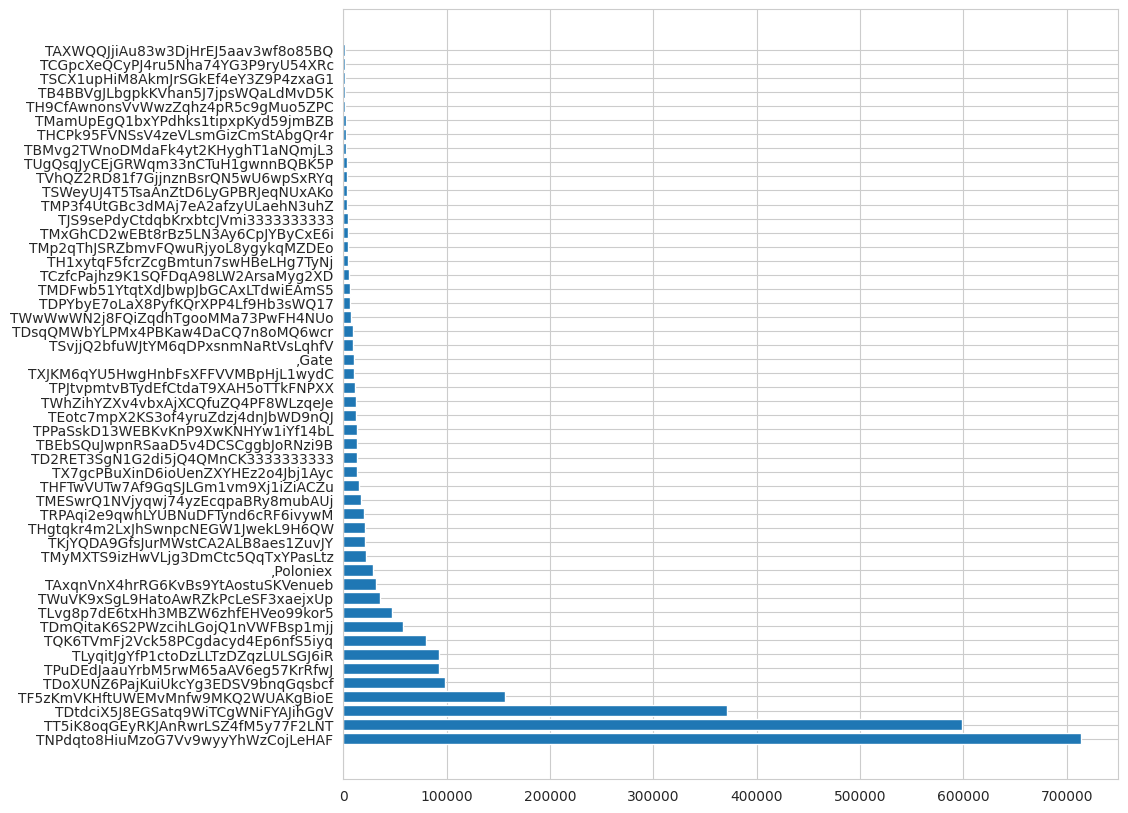

In [86]:
q = client.query(f'select count(*) as cnt, ownerAddress from tron.delegateResourceContracts where resource = 0 group by ownerAddress order by cnt desc limit 50')
result = list(q.named_results())
print(result)

others = 0
data = []
labels = []
for i, r in enumerate(result):
    name = r["ownerAddress"].decode()
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(name)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )
# plt.legend(labels)

[{'amount': 9133107515843601, 'ownerAddress': b'TKjYQDA9GfsJurMWstCA2ALB8aes1ZuvJY'}, {'amount': 3060588759000000, 'ownerAddress': b'TWuVK9xSgL9HatoAwRZkPcLeSF3xaejxUp'}, {'amount': 1116119086000000, 'ownerAddress': b'TJS9sePdyCtdqbKrxbtcJVmi3333333333'}, {'amount': 463506505000000, 'ownerAddress': b'TWd4WrZ9wn84f5x1hZhL4DHvk738ns5jwb'}, {'amount': 438310236456506, 'ownerAddress': b'TPJtvpmtvBTydEfCtdaT9XAH5oTTkFNPXX'}, {'amount': 309140120463917, 'ownerAddress': b'TQK6TVmFj2Vck58PCgdacyd4Ep6nfS5iyq'}, {'amount': 277727979251436, 'ownerAddress': b'TT5iK8oqGEyRKJAnRwrLSZ4fM5y77F2LNT'}, {'amount': 219368583000000, 'ownerAddress': b'TE3KB58e3znmg7gRL2pr23RJTj1ZMpoLgr'}, {'amount': 173159855889456, 'ownerAddress': b'TDtdciX5J8EGSatq9WiTCgWNiFYAJihGgV'}, {'amount': 113640052000000, 'ownerAddress': b'TGmbGB7uMHTfYmhjyNNpSH824Vrj3tTKEu'}, {'amount': 106591023394567, 'ownerAddress': b'TNPdqto8HiuMzoG7Vv9wyyYhWzCojLeHAF'}, {'amount': 57121136000000, 'ownerAddress': b'TAm937jKKHTgJ8qsBuW8CwSRL9s

<BarContainer object of 50 artists>

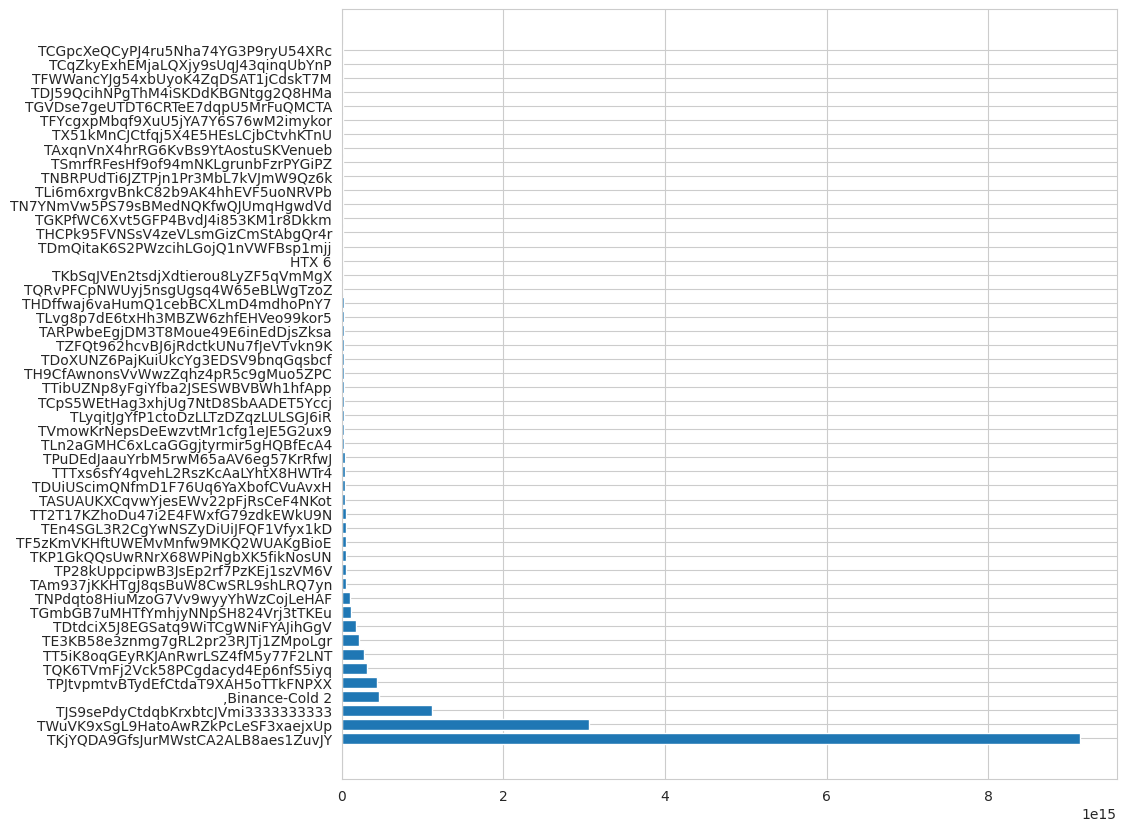

In [87]:
q = client.query(f'select sum(balance) as amount, ownerAddress from tron.delegateResourceContracts where resource = 0 group by ownerAddress order by amount desc limit 50')
result = list(q.named_results())
print(result)

others = 0
data = []
labels = []
for i, r in enumerate(result):
    name = r["ownerAddress"].decode()
    data.append(r["amount"])
    labels.append(f"{get_contract_name(name)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

## triggerSmartContracts

```sql
select count(distinct address) from tron.triggerSmartContracts
```

In [88]:
q = client.query(f'select contractAddress, count(*) as cnt from tron.triggerSmartContracts group by contractAddress order by cnt desc')
result = list(q.named_results())
print("query done")


others = 0
data = []
labels = []
for i, r in enumerate(result):
    if i > 20:
        others += r["cnt"]
        continue
    address = r["contractAddress"].decode("utf-8")
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(address)} {r['cnt']}")

data.append(others)
labels.append(f"others {others}")

query done
no name found for TK5qKN9xJoLfCzZPG6Mj642WQtvbiHCTMx
no name found for TXSjGe7jtfHwiTFxxfER8PKVz9vc1N8u2x
no name found for TV7rB5oK44V3MNS3CKWpQBF6piyeQB6fMt
no name found for TVkNuE1BYxECWq85d8UR9zsv6WppBns9iH
no name found for TGVtEmiB9EH4Rt1sEvvsaaBCQHvBVEkvYN
no name found for TSQyuZowokRp3TMRCcrbsDnhnnDSg7gtMT
no name found for TK9CYa8SU17Kk95Hy9cktp9mBiKYUccTWS


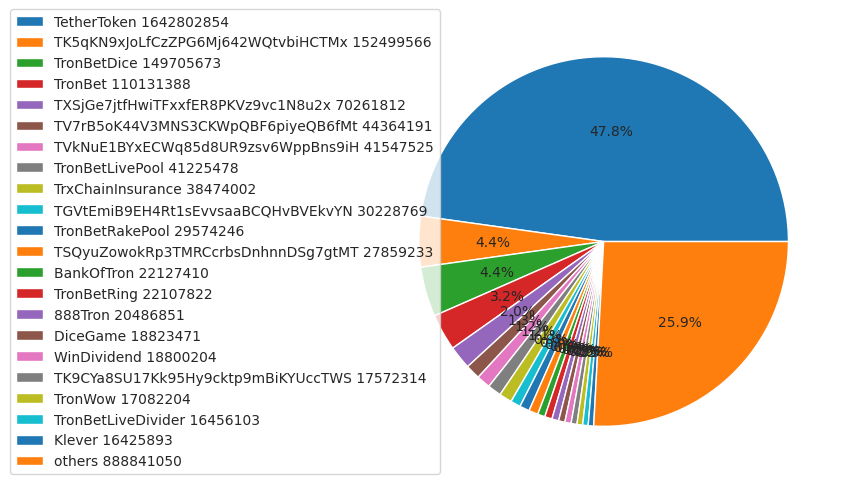

In [89]:
sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6)) # Set figure size
plt.pie(data, autopct='%1.1f%%') # Create pie chart
plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
plt.show() # Show chart

In [90]:
q = client.query(f'select address, count(*) as cnt from tron.logs group by address order by cnt desc')
result = list(q.named_results())
print("query done")

others = 0
data = []
labels = []
for i, r in enumerate(result):
    if i > 20:
        others += r["cnt"]
        continue
    address = r["address"].decode("utf-8")
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(address)} {r['cnt']}")

data.append(others)
labels.append(f"others {others}")

query done
no name found for TV7rB5oK44V3MNS3CKWpQBF6piyeQB6fMt
no name found for TJcwhNAGdZev49UzsYdVDE4mMhB1dWb283
no name found for TFRLPB1kiCyKRSM9e7vFn8KqN66qeTGVUv
no name found for TK9CYa8SU17Kk95Hy9cktp9mBiKYUccTWS
no name found for TGVtEmiB9EH4Rt1sEvvsaaBCQHvBVEkvYN
no name found for TSQyuZowokRp3TMRCcrbsDnhnnDSg7gtMT
no name found for TS8CGCtAW9usUacKVd2irDtsXQtEaPkSXH


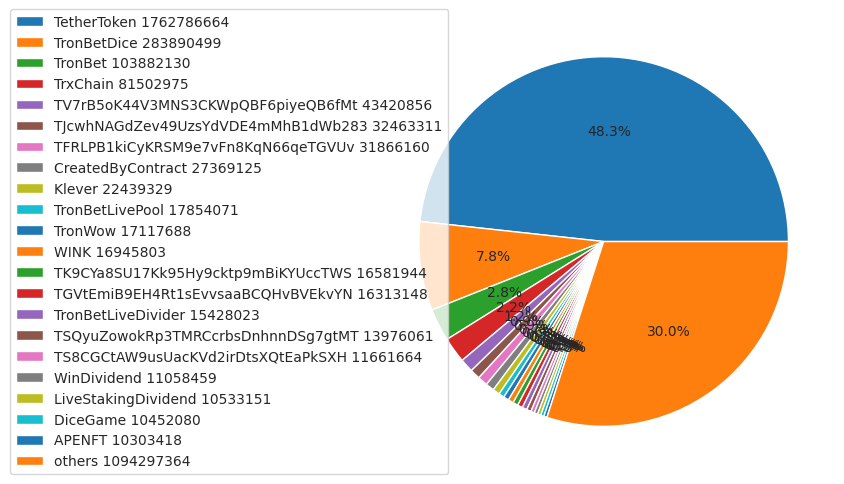

In [91]:
sns.set_style("whitegrid") # Set style for chart
plt.figure(figsize=(6,6)) # Set figure size
plt.pie(data, autopct='%1.1f%%') # Create pie chart
plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
plt.show() # Show chart

In [92]:
USDT_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"

q = client.query(f"select topic0, count(*) as cnt from tron.logs where address='{USDT_ADDRESS}' group by topic0 order by cnt desc")
result = list(q.named_results())
for r in result:
    print(r["cnt"], r["topic0"].hex())
    

1750695957 ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
12089253 8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925
805 42e160154868087d6bfdc0ca23d96a1c1cfa32f1b72ba9ba27b69b98a0d819dc
303 61e6e66b0d6339b2980aecc6ccc0039736791f0ccde9ed512e789a7fbdd698c6
257 cb8241adb0c3fdb35b70c24ce35c5eb0c17af7431c99f827d44a445ca624176a
51 d7e9ec6e6ecd65492dce6bf513cd6867560d49544421d0783ddf06e76c24470c
37 702d5967f45f6513a38ffc42d6ba9bf230bd40e8f53b16363c7eb4fd2deb9a44
1 8be0079c531659141344cd1fd0a4f28419497f9722a3daafe3b4186f6b6457e0


In [93]:

USDT_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"
TOPIC0 = "ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
q = client.query(f"select topic1, count(*) as cnt from tron.logs where address='{USDT_ADDRESS}' and topic0 = unhex('{TOPIC0}') group by topic1 order by cnt desc limit 50")
result = list(q.named_results())


In [94]:
others = 0
data = []
labels = []
for i, r in enumerate(result):
    address = hexlify(r["topic1"]).decode()
    name = get_contract_name(hex2Taddr(address))
    data.append(r["cnt"])
    labels.append(f"{name} {r['cnt']}")


no name found for TRuDTw1wxUQ4tnMy4VnMt9akFNZYZQi3w9
no name found for TBRs8xwajQVbDLT11SKZwFbsnJXRCKMi9x
no name found for TCb1jjfKYZkNWqNn2XYSDmYHCroWSQ8MJg
no name found for TY4fknjjsRGx3u6Pn8r34qFxUAWfJGK7Py
no name found for TJtf2PvZ6D37qHfweqyWuzD3DgM1BXQE6n
no name found for TPMF2n3hJLcCwoHq6bwLeVXBbNZgj73AEd
no name found for TFp4V3S9JqJyQAMMCewyn4aAaLueJwzS7H
no name found for TJEw7U8a4Asoh83EoB5Pk5YyfTadVZbb8h
no name found for TWDchZBmYvTQBeXD4w8rRUowDv5ka8kiFU
no name found for TWS1onJnNTg8tJHomceqxBxTsUB1DHh7PV
no name found for TFRcvbDGWEamSXoCB7j95M3rvMHaVwDmRj
no name found for TUHpMF2TkFaJrowUYMzpuY8rzL4kNXXkuE
no name found for TQf9d2g2aF4nPQVehvWpkKedhaoGQhAr5c
no name found for TVZF4Ukxa7zoUsui3FtYBZBNJVXrxorH9Q
no name found for TKMp9bYo84o9bb5aqfnH4HXPQbaGL2nb1e
no name found for TTgZJfgf6E63Wb8Wdkcg4qM8nZQGKSuFr6
no name found for TW3WXRdrzU61oVdu8uQyxzGVfYefGqkCmt
no name found for TYjRscy38QKw7dJuNDz6zZtBr2s6gkobHH
no name found for TLYCaS9cZErMpUuwjZQbkFvYqx6Z

<BarContainer object of 50 artists>

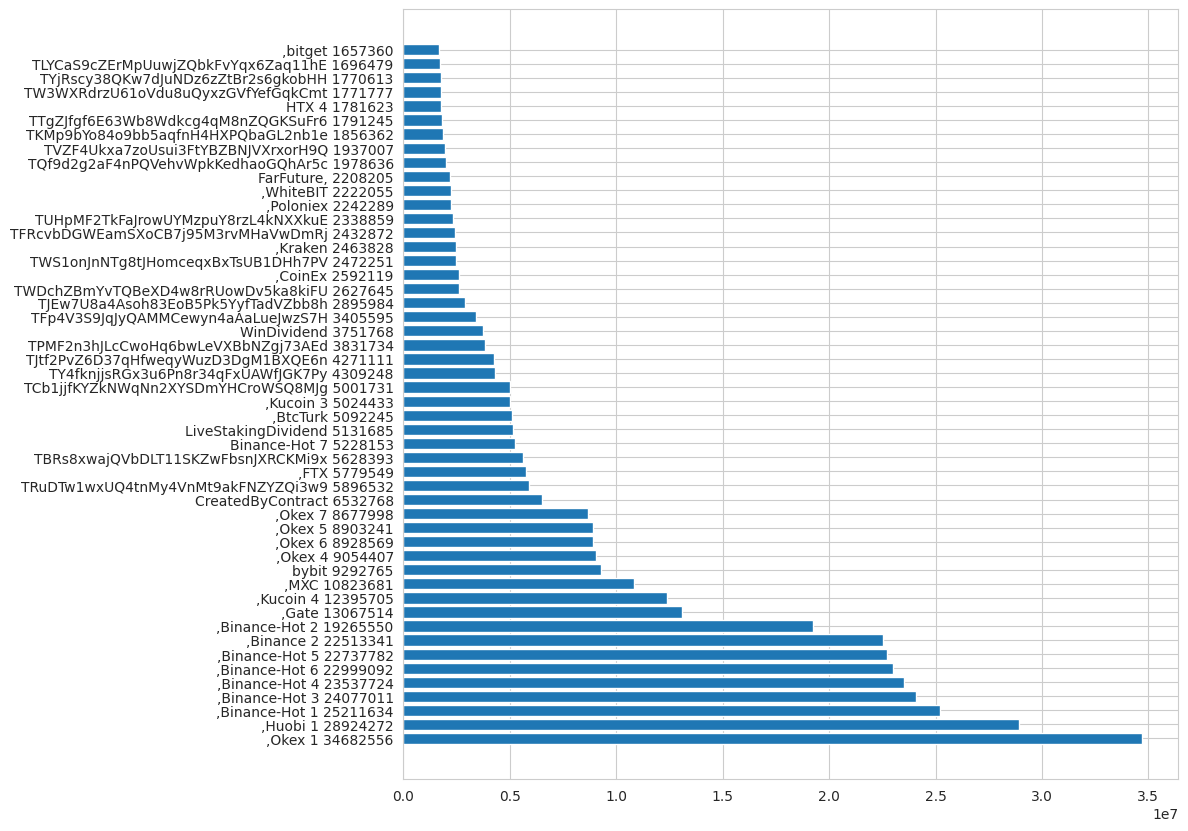

In [95]:
# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
# plt.show() # Show chart
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

no name found for TY4fknjjsRGx3u6Pn8r34qFxUAWfJGK7Py
no name found for TFp4V3S9JqJyQAMMCewyn4aAaLueJwzS7H
no name found for TWS1onJnNTg8tJHomceqxBxTsUB1DHh7PV
no name found for TS9b9boewmB6tq874PnVZrKPf4NZw9qHPi
no name found for TWDchZBmYvTQBeXD4w8rRUowDv5ka8kiFU
no name found for TMepesyArZzc5ifTXRvjnbWTbsXdhbaBk1
no name found for TAm937jKKHTgJ8qsBuW8CwSRL9shLRQ7yn
no name found for TLYCaS9cZErMpUuwjZQbkFvYqx6Zaq11hE
no name found for TAJfRnRfBJkFKzEoErjJYTrHmUUSUMnbaL
no name found for TUpLKv7vjKW3ph2kUnNRC3YygFaRy24NQ8
no name found for TH8NXiGpdwcW8BMZuy2C8zs5CMdYjjTADz
no name found for TJEw7U8a4Asoh83EoB5Pk5YyfTadVZbb8h
no name found for TXZwTjx6CAid2G3gqfnGrYKjEuPwm61HFb
no name found for TELhSFWi8E373bXJYNEV3Nt4CotECfRY6D
no name found for TGx3Lyc6rR14keStqfAK8u37euNFaq8uZ4
no name found for TZ5hmVevyuyoAe5Vk3nTsv6ENnLCsWKb7j
no name found for TQtaugi3vfFuqxp8KCQUTyXDc6Smk1pYDJ
no name found for TJwT1J97d2cZjqyhVuQRQ4YtmymFvMyPxB
no name found for THmseTyfuKVqy67pAkGfKk3GT3da

<BarContainer object of 50 artists>

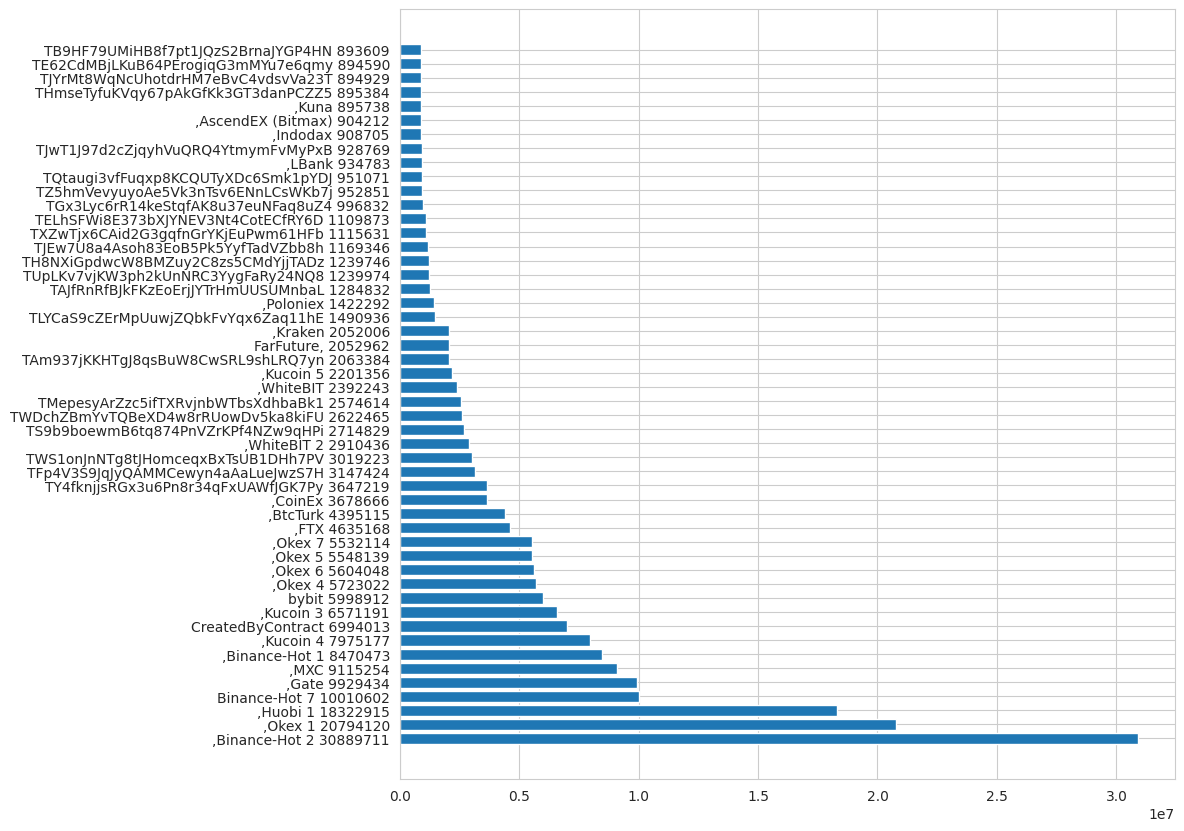

In [96]:
USDT_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"
TOPIC0 = "ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
q = client.query(f"select topic2, count(*) as cnt from tron.logs where address='{USDT_ADDRESS}' and topic0 = unhex('{TOPIC0}') group by topic2 order by cnt desc limit 50")
result = list(q.named_results())


others = 0
data = []
labels = []
for i, r in enumerate(result):
    # if r["cnt"] < 1_000_000:
    #     others += r["cnt"]
    #     continue
    address = hexlify(r["topic2"]).decode()
    name = get_contract_name(hex2Taddr(address))
    data.append(r["cnt"])
    labels.append(f"{name} {r['cnt']}")

# data.append(others)
# labels.append(f"others {others}")

# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
# plt.show() # Show chart
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

no name found for TCTrwC2rxGFRS74XihgdMkp5mLYGezdrDL
no name found for THPvaUhoh2Qn2y9THCZML3H815hhFhn5YC
no name found for TNMDwbHyAQo38tK4fCYe4ooSZXesbK8ExZ
no name found for TCP5CkoAaEEwYYTtrJzstN1Ny2oRULM692
no name found for TQef1npDuBwGCVXKY5SE9A1BdPSEYzk32t
no name found for TNbwqdsXYKAPbGGGRS8Dk5m8HTXvWC67hk
no name found for TPxAJYBTkRVLDyWfVBVfCV9PDqCW2q276v
no name found for TNvxy1cstZwzobWEJDKAXPYw1DZ11nCW7t
no name found for TWDchZBmYvTQBeXD4w8rRUowDv5ka8kiFU
no name found for TAkam7aue3mWcvxhivnSQyNPkPRdWT7beL
no name found for TSFLsb1dgX8KGcAXewPvWpoV7RfsZ8wk78
no name found for TY4fknjjsRGx3u6Pn8r34qFxUAWfJGK7Py
no name found for TMhJviFWiaxvqKLdng9dmsi1H5H5yTGEeu
no name found for TAKBTyyqMxG96AiSyTWtz1pWBbr1DzZSHj
no name found for TQ7wK19fhZZqLdj2Xcw2e6Ejs3cTZbfBbF
no name found for TK6SJby92kxqFWr8Mxdn89xKAXSRTGBo26
no name found for TD73eXvY2FdxYsx38ZbXBreSDqnbeLoF4f


<BarContainer object of 51 artists>

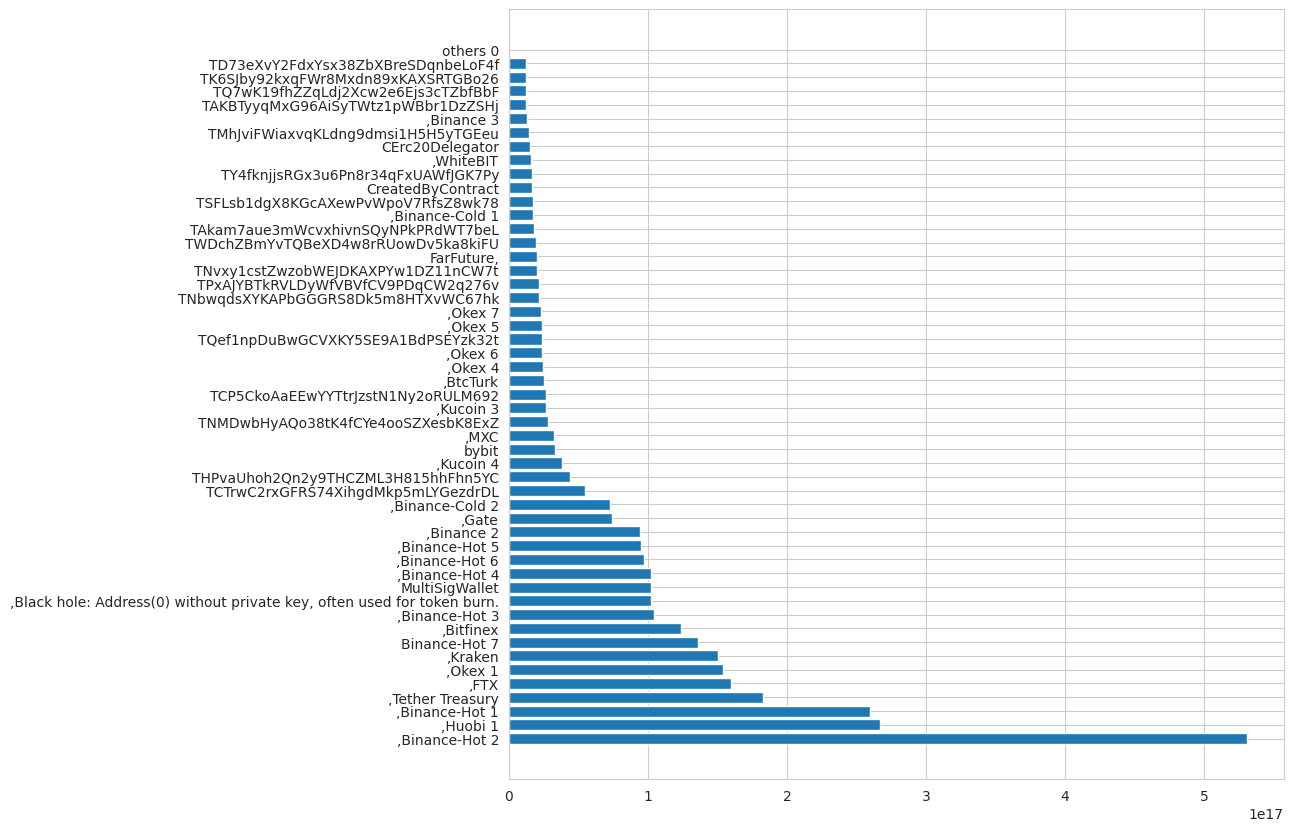

In [97]:
USDT_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"
TOPIC0 = "ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
q = client.query(f"select topic1, sum(reinterpret(reverse(data), 'UInt256')) as amount from tron.logs where address='{USDT_ADDRESS}' and topic0 = unhex('{TOPIC0}') group by topic1 order by amount desc limit 50")
result = list(q.named_results())


others = 0
data = []
labels = []
for i, r in enumerate(result):
    # if r["amount"] < 1_000_000:
    #     others += r["amount"]
    #     continue
    address = hexlify(r["topic1"]).decode()
    name = get_contract_name(hex2Taddr(address))
    data.append(r["amount"])
    labels.append(f"{name}")

data.append(others)
labels.append(f"others {others}")

# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
# plt.show() # Show chart
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

no name found for TCTrwC2rxGFRS74XihgdMkp5mLYGezdrDL
no name found for THPvaUhoh2Qn2y9THCZML3H815hhFhn5YC
no name found for TNMDwbHyAQo38tK4fCYe4ooSZXesbK8ExZ
no name found for TCP5CkoAaEEwYYTtrJzstN1Ny2oRULM692
no name found for TQef1npDuBwGCVXKY5SE9A1BdPSEYzk32t
no name found for TNbwqdsXYKAPbGGGRS8Dk5m8HTXvWC67hk
no name found for TPxAJYBTkRVLDyWfVBVfCV9PDqCW2q276v
no name found for TNvxy1cstZwzobWEJDKAXPYw1DZ11nCW7t
no name found for TWDchZBmYvTQBeXD4w8rRUowDv5ka8kiFU
no name found for TAkam7aue3mWcvxhivnSQyNPkPRdWT7beL
no name found for TSFLsb1dgX8KGcAXewPvWpoV7RfsZ8wk78
no name found for TY4fknjjsRGx3u6Pn8r34qFxUAWfJGK7Py
no name found for TMhJviFWiaxvqKLdng9dmsi1H5H5yTGEeu
no name found for TQ7wK19fhZZqLdj2Xcw2e6Ejs3cTZbfBbF
no name found for TAKBTyyqMxG96AiSyTWtz1pWBbr1DzZSHj
no name found for TK6SJby92kxqFWr8Mxdn89xKAXSRTGBo26
no name found for TD73eXvY2FdxYsx38ZbXBreSDqnbeLoF4f


<BarContainer object of 51 artists>

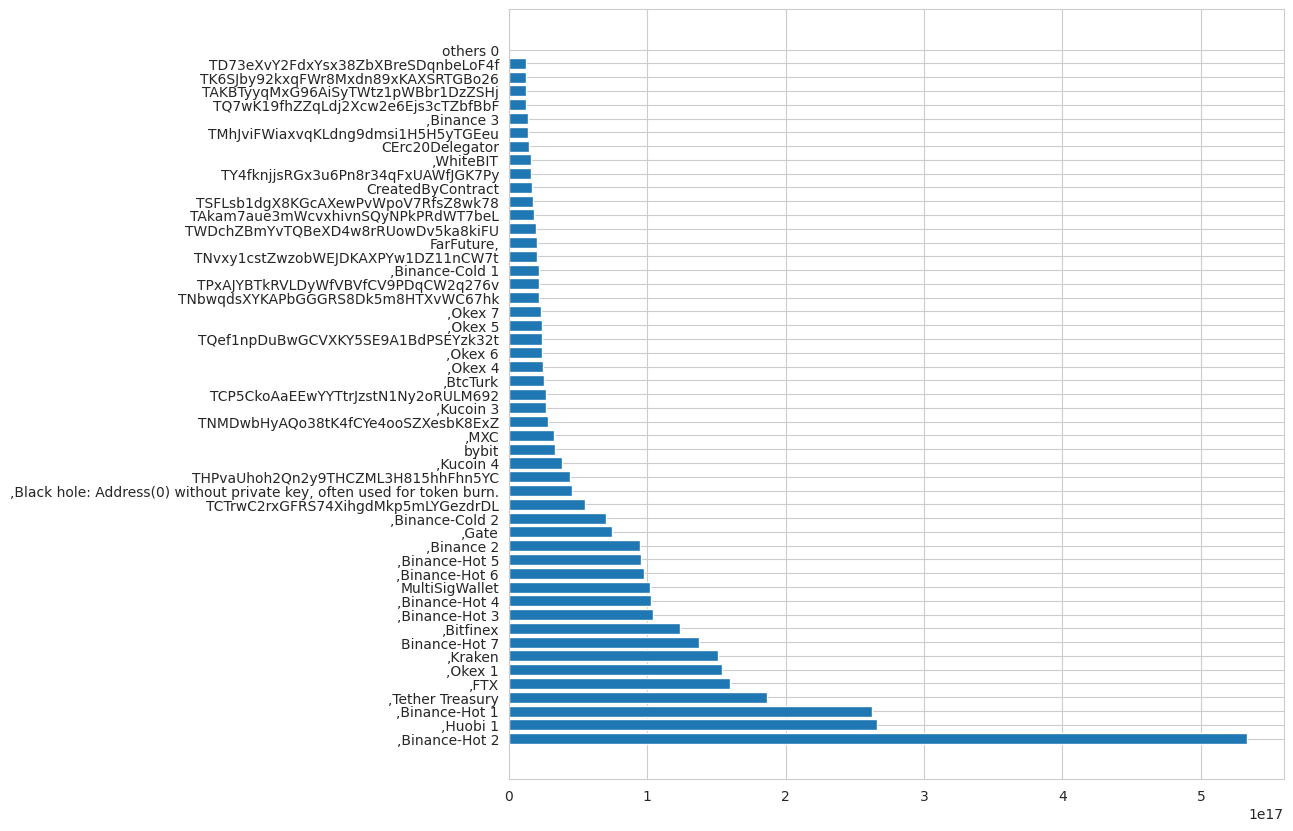

In [98]:
USDT_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"
TOPIC0 = "ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
q = client.query(f"select topic2, sum(reinterpret(reverse(data), 'UInt256')) as amount from tron.logs where address='{USDT_ADDRESS}' and topic0 = unhex('{TOPIC0}') group by topic2 order by amount desc limit 50")
result = list(q.named_results())


others = 0
data = []
labels = []
for i, r in enumerate(result):
    address = hexlify(r["topic2"]).decode()
    name = get_contract_name(hex2Taddr(address))
    data.append(r["amount"])
    labels.append(f"{name}")

data.append(others)
labels.append(f"others {others}")

# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
# plt.show() # Show chart
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

### Approval

no name found for TCb1jjfKYZkNWqNn2XYSDmYHCroWSQ8MJg
no name found for THwa8pHMDRBKubnYy4UJEx6ky2Nf9AGdcV
no name found for TC6VzM9TGU4BTtkYgocy49jxQQydqg1Awu
no name found for TGZHZ4fzKfvyKDt77d2KBRJEJARZBPdpuL
no name found for TJH8ssZQLXzJmeVHYHgCakD1TrBrjT7SrD
no name found for TBRs8xwajQVbDLT11SKZwFbsnJXRCKMi9x
no name found for TXvJHPav9B36t2XAsMS4KdDmu95wP8WzUu
no name found for TVZF4Ukxa7zoUsui3FtYBZBNJVXrxorH9Q
no name found for TKcawB4EHH6ansTumE1X78TataB9WE7XRg
no name found for TPFQyLBqcR7Pmhyeyei9jZRYjef3ugCeXD
no name found for TR9mQaFHV4Y3vtWPsaKgoMDWSN66vHYVMA
no name found for TZDSbKHtAF7UJPZmTgbx7EvFCpgKHX295g
no name found for TTVeP6ozAaSkPwkvtxgNGrBEG1QiBqyytd
no name found for TRhE4KCxX6omHZV4igk1g6WbPDAyTmrZTm
no name found for TN6HMVkpgjJPGCfqihWFd3mrWQ5SQ1Es63
no name found for TLPiduJ775imccG8z3c2oLHhtBxoAaDiHV
no name found for TKmtXMbzPDvzWb8hgLwTCu8GP2ZxrNxHGH
no name found for TR8jiskVjHoeNNSmqBYVewAy688Eup7ouz
no name found for TV4PTL6xDscZ6rPgRsydpTbAkipe

<BarContainer object of 50 artists>

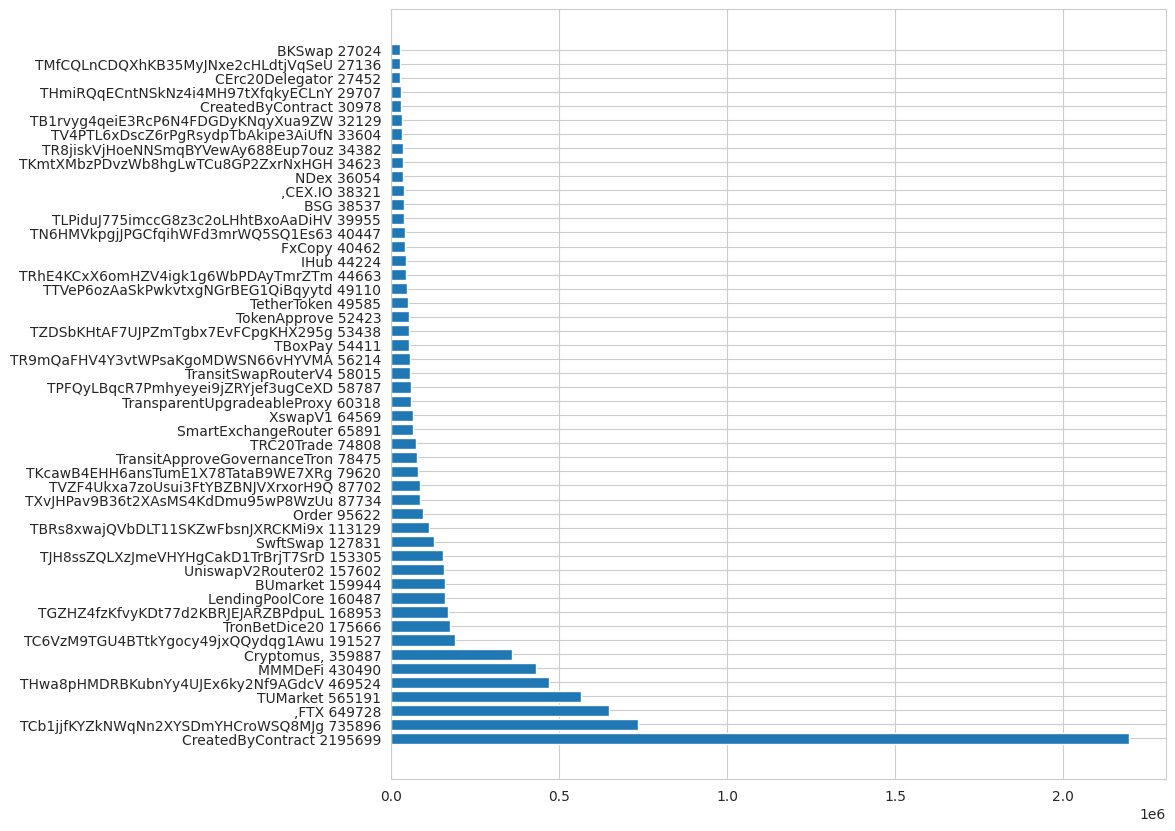

In [99]:
USDT_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"
TOPIC0 = "8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925"
q = client.query(f"select topic2, count(*) as cnt from tron.logs where address='{USDT_ADDRESS}' and topic0 = unhex('{TOPIC0}') group by topic2 order by cnt desc limit 50")
result = list(q.named_results())


others = 0
data = []
labels = []
for i, r in enumerate(result):
    # if r["cnt"] < 1_000_000:
    #     others += r["cnt"]
    #     continue
    address = hexlify(r["topic2"]).decode()
    name = get_contract_name(hex2Taddr(address))
    data.append(r["cnt"])
    labels.append(f"{name} {r['cnt']}")

# data.append(others)
# labels.append(f"others {others}")

# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
# plt.show() # Show chart
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

no name found for TCb1jjfKYZkNWqNn2XYSDmYHCroWSQ8MJg
no name found for THwa8pHMDRBKubnYy4UJEx6ky2Nf9AGdcV
no name found for TC6VzM9TGU4BTtkYgocy49jxQQydqg1Awu
no name found for TGZHZ4fzKfvyKDt77d2KBRJEJARZBPdpuL
no name found for TJH8ssZQLXzJmeVHYHgCakD1TrBrjT7SrD
no name found for TBRs8xwajQVbDLT11SKZwFbsnJXRCKMi9x
no name found for TXvJHPav9B36t2XAsMS4KdDmu95wP8WzUu
no name found for TVZF4Ukxa7zoUsui3FtYBZBNJVXrxorH9Q
no name found for TKcawB4EHH6ansTumE1X78TataB9WE7XRg
no name found for TPFQyLBqcR7Pmhyeyei9jZRYjef3ugCeXD
no name found for TR9mQaFHV4Y3vtWPsaKgoMDWSN66vHYVMA
no name found for TZDSbKHtAF7UJPZmTgbx7EvFCpgKHX295g
no name found for TTVeP6ozAaSkPwkvtxgNGrBEG1QiBqyytd
no name found for TRhE4KCxX6omHZV4igk1g6WbPDAyTmrZTm
no name found for TN6HMVkpgjJPGCfqihWFd3mrWQ5SQ1Es63
no name found for TLPiduJ775imccG8z3c2oLHhtBxoAaDiHV
no name found for TKmtXMbzPDvzWb8hgLwTCu8GP2ZxrNxHGH
no name found for TR8jiskVjHoeNNSmqBYVewAy688Eup7ouz
no name found for TV4PTL6xDscZ6rPgRsydpTbAkipe

<BarContainer object of 50 artists>

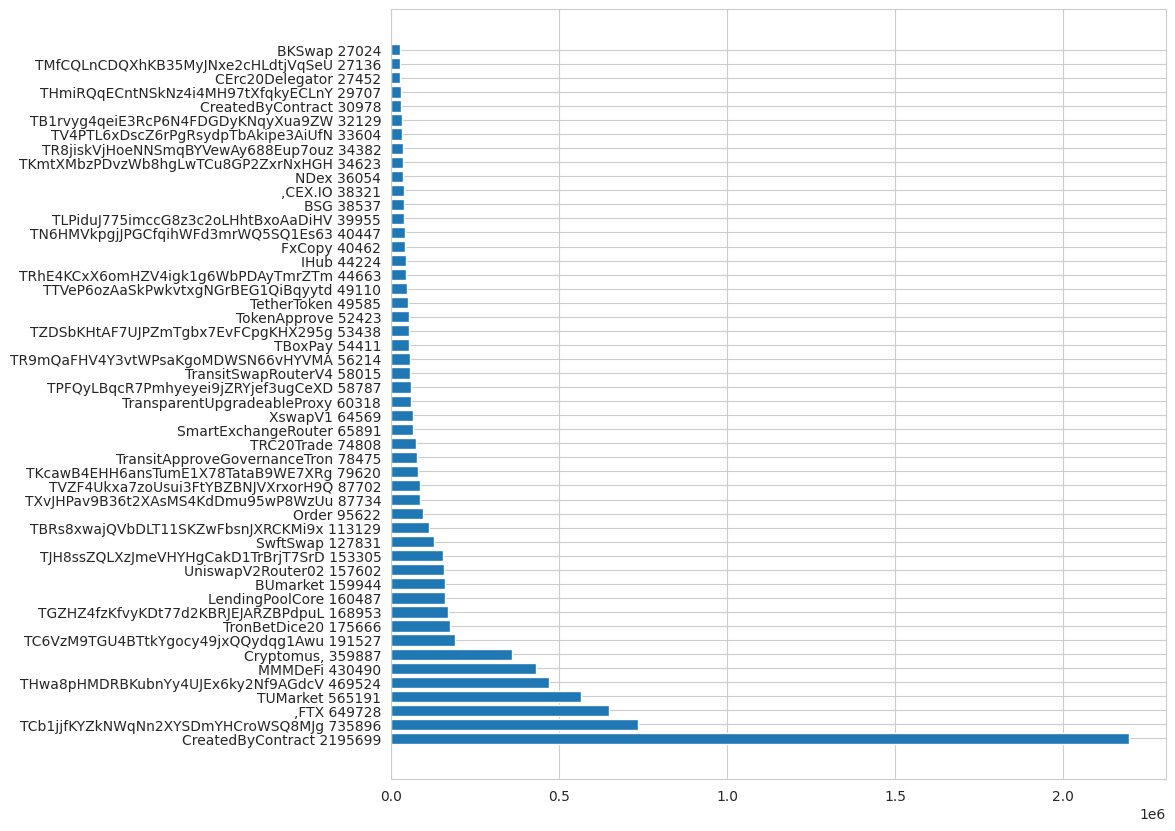

In [100]:
q = client.query(f"select topic2, count(*) as cnt from tron.logs where address='{USDT_ADDRESS}' and topic0 = unhex('{TOPIC0}') group by topic2 order by cnt desc limit 50")
result = list(q.named_results())

others = 0
data = []
labels = []
for i, r in enumerate(result):
    # if r["cnt"] < 1_000_000:
    #     others += r["cnt"]
    #     continue
    address = hexlify(r["topic2"]).decode()
    name = get_contract_name(hex2Taddr(address))
    data.append(r["cnt"])
    labels.append(f"{name} {r['cnt']}")

# data.append(others)
# labels.append(f"others {others}")

# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.8, 0.5))
# plt.show() # Show chart
plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

<BarContainer object of 50 artists>

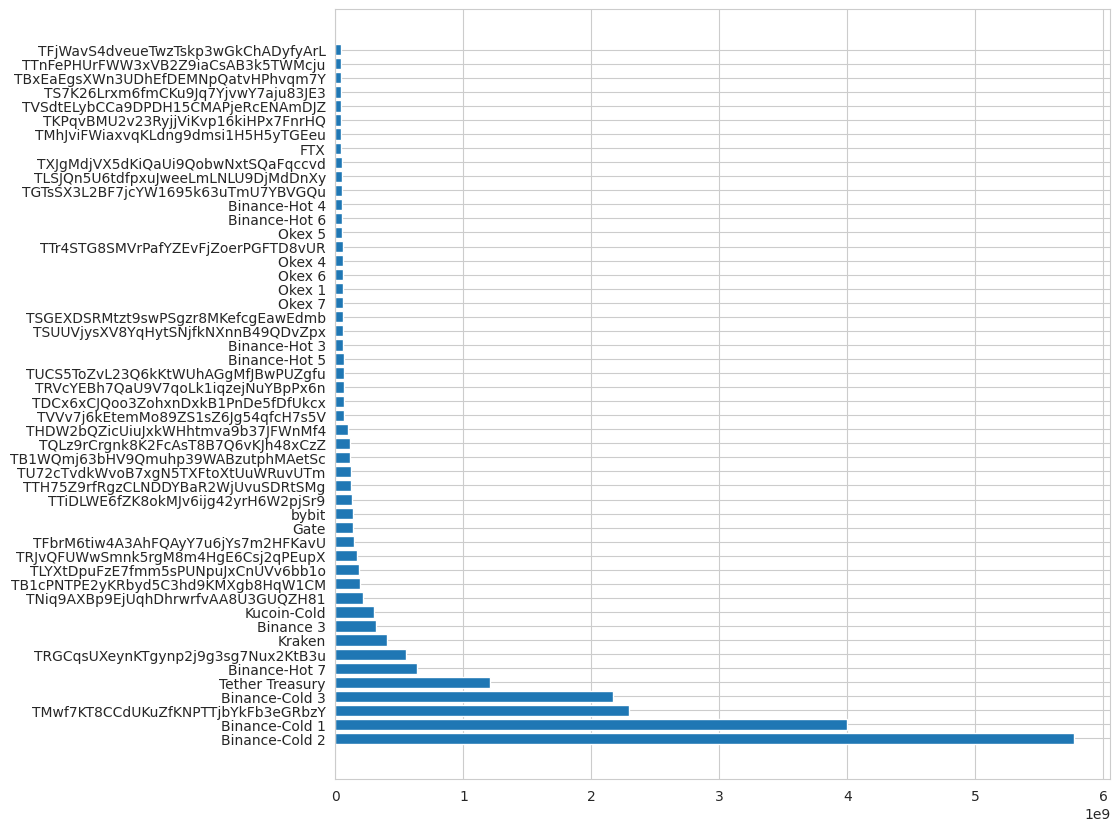

In [101]:
# resp = requests.get("https://apilist.tronscanapi.com/api/stableCoin/holder/top?viewContract=true&sort=USDT&direction=2")
resp_body = json.loads('{"total":50,"data":[{"address":"TWd4WrZ9wn84f5x1hZhL4DHvk738ns5jwb","addressType":1,"accountTag":"Binance-Cold 2","usdtAmount":5767463593.543494,"tusdAmount":3709195.976300252116851410,"usddAmount":0.000431736076562944},{"address":"TMuA6YqfCeX8EhbfYEg5y7S4DqzSJireY9","addressType":1,"accountTag":"Binance-Cold 1","usdtAmount":4000914090.290989,"usddAmount":0.000264701265386571},{"address":"TMwf7KT8CCdUKuZfKNPTTjbYkFb3eGRbzY","addressType":1,"accountTag":"","usdtAmount":2292662636.473985},{"address":"TT1DyeqXaaJkt6UhVYFWUXBXknaXnBudTK","addressType":1,"accountTag":"Binance-Cold 3","usdtAmount":2165853302.945307,"usddAmount":0.000087389739909453},{"address":"TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs","addressType":1,"accountTag":"Tether Treasury","usdtAmount":1210139240.357385,"usddAmount":0.000177042212446563},{"address":"TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf","addressType":1,"accountTag":"Binance-Hot 7","usdtAmount":633302544.226241,"tusdAmount":4112721.181663423954122916,"usdcAmount":8903172.081548},{"address":"TRGCqsUXeynKTgynp2j9g3sg7Nux2KtB3u","addressType":1,"accountTag":"","usdtAmount":550217389.189484},{"address":"TTd9qHyjqiUkfTxe3gotbuTMpjU8LEbpkN","addressType":1,"accountTag":"Kraken","usdtAmount":401418854.355662,"tusdAmount":158693.280840981738846144,"usddAmount":0.000503851647800957,"usdcAmount":1127758.003837},{"address":"TJCo98saj6WND61g1uuKwJ9GMWMT9WkJFo","addressType":1,"accountTag":"Binance 3","usdtAmount":315619953.072454},{"address":"TRYL7PKCG4b4xRCM554Q5J6o8f1UjUmfnY","addressType":1,"accountTag":"Kucoin-Cold","usdtAmount":298200451.269731,"usdjAmount":10.776194843592290000,"tusdAmount":43.000089232023110481,"usddAmount":309406.340757901220539091,"usdcAmount":138296.167299},{"address":"TNiq9AXBp9EjUqhDhrwrfvAA8U3GUQZH81","addressType":1,"accountTag":"","usdtAmount":213006593.300959,"usddAmount":0.000132426749069551},{"address":"TB1cPNTPE2yKRbyd5C3hd9KMXgb8HqW1CM","addressType":1,"accountTag":"","usdtAmount":191239409.700210,"usdcAmount":0.003411},{"address":"TLYXtDpuFzE7fmm5sPUNpuJxCnUVv6bb1o","addressType":1,"accountTag":"","usdtAmount":180071146.553317},{"address":"TRJvQFUWwSmnk5rgM8m4HgE6Csj2qPEupX","addressType":1,"accountTag":"","usdtAmount":169388615.978369,"usdcAmount":150.050411},{"address":"TFbrM6tiw4A3AhFQAyY7u6jYs7m2HFKavU","addressType":1,"accountTag":"","usdtAmount":148291637.467865},{"address":"TBA6CypYJizwA9XdC7Ubgc5F1bxrQ7SqPt","addressType":1,"accountTag":"Gate","usdtAmount":139817840.991607,"tusdAmount":22564.178598887628533291,"usddAmount":170368.189600023106027600,"usdcAmount":2798.041769},{"address":"TU4vEruvZwLLkSfV9bNw12EJTPvNr7Pvaa","addressType":1,"accountTag":"bybit","usdtAmount":138187487.432256,"tusdAmount":198816.415224748557939335,"usddAmount":181193.652962308942431228,"usdcAmount":1.000336},{"address":"TTiDLWE6fZK8okMJv6ijg42yrH6W2pjSr9","addressType":1,"accountTag":"","usdtAmount":131340463.425623,"usddAmount":0.000138984230994805},{"address":"TTH75Z9rfRgzCLNDDYBaR2WjUvuSDRtSMg","addressType":1,"accountTag":"","usdtAmount":124549296.198404},{"address":"TU72cTvdkWvoB7xgN5TXFtoXtUuWRuvUTm","addressType":1,"accountTag":"","usdtAmount":118636873.061784},{"address":"TB1WQmj63bHV9Qmuhp39WABzutphMAetSc","addressType":1,"accountTag":"","usdtAmount":114420716.768373},{"address":"TQLz9rCrgnk8K2FcAsT8B7Q6vKJh48xCzZ","addressType":1,"accountTag":"","usdtAmount":113778591.689530,"usddAmount":0.580000000000000000},{"address":"THDW2bQZicUiuJxkWHhtmva9b37JFWnMf4","addressType":1,"accountTag":"","usdtAmount":94263848.076435},{"address":"TVVv7j6kEtemMo89ZS1sZ6Jg54qfcH7s5V","addressType":1,"accountTag":"","usdtAmount":68818542.468968},{"address":"TDCx6xCJQoo3ZohxnDxkB1PnDe5fDfUkcx","addressType":2,"accountTag":"","usdtAmount":68354004.312240},{"address":"TRVcYEBh7QaU9V7qoLk1iqzejNuYBpPx6n","addressType":1,"accountTag":"","usdtAmount":67419442.385295,"usddAmount":0.000193646184803450},{"address":"TUCS5ToZvL23Q6kKtWUhAGgMfJBwPUZgfu","addressType":1,"accountTag":"","usdtAmount":65819836.517612},{"address":"TAzsQ9Gx8eqFNFSKbeXrbi45CuVPHzA8wr","addressType":1,"accountTag":"Binance-Hot 5","usdtAmount":65156688.455697,"usddAmount":0.000253488461433452},{"address":"TYASr5UV6HEcXatwdFQfmLVUqQQQMUxHLS","addressType":1,"accountTag":"Binance-Hot 3","usdtAmount":62322054.057423,"usddAmount":5.257987006238335315},{"address":"TSUUVjysXV8YqHytSNjfkNXnnB49QDvZpx","addressType":2,"accountTag":"","usdtAmount":61856926.810834},{"address":"TSGEXDSRMtzt9swPSgzr8MKefcgEawEdmb","addressType":1,"accountTag":"","usdtAmount":61024110.953642,"usdjAmount":10776.194843592290000000,"tusdAmount":0.777532400667538838,"usddAmount":26941.766366674611772187,"usdcAmount":32056.374379},{"address":"TSaRZDiBPD8Rd5vrvX8a4zgunHczM9mj8S","addressType":1,"accountTag":"Okex 7","usdtAmount":56742720.135566},{"address":"TM1zzNDZD2DPASbKcgdVoTYhfmYgtfwx9R","addressType":1,"accountTag":"Okex 1","usdtAmount":56345276.414468,"tusdAmount":109.853076742805438656,"usddAmount":4186.914188165456957908,"usdcAmount":157000.171338},{"address":"TJbHp48Shg4tTD5x6fKkU7PodggL5mjcJP","addressType":1,"accountTag":"Okex 6","usdtAmount":56313578.449375},{"address":"TCz47XgC9TjCeF4UzfB6qZbM9LTF9s1tG7","addressType":1,"accountTag":"Okex 4","usdtAmount":56266371.626120},{"address":"TTr4STG8SMVrPafYZEvFjZoerPGFTD8vUR","addressType":1,"accountTag":"","usdtAmount":55071771.686740},{"address":"TWGZbjofbTLY3UCjCV4yiLkRg89zLqwRgi","addressType":1,"accountTag":"Okex 5","usdtAmount":54693816.316335,"usddAmount":0.000010000000000000},{"address":"TJDENsfBJs4RFETt1X1W8wMDc8M5XnJhCe","addressType":1,"accountTag":"Binance-Hot 6","usdtAmount":50944263.895836,"usddAmount":0.000250720892579450},{"address":"TNXoiAJ3dct8Fjg4M9fkLFh9S2v9TXc32G","addressType":1,"accountTag":"Binance-Hot 4","usdtAmount":50885383.244252,"tusdAmount":528206.353412392860701740,"usddAmount":1.336237048244512603,"usdcAmount":6.809517},{"address":"TGTsSX3L2BF7jcYW1695k63uTmU7YBVGQu","addressType":1,"accountTag":"","usdtAmount":50029977.989637},{"address":"TLSJQn5U6tdfpxuJweeLmLNLU9DjMdDnXy","addressType":1,"accountTag":"","usdtAmount":50019763.108318},{"address":"TXJgMdjVX5dKiQaUi9QobwNxtSQaFqccvd","addressType":2,"accountTag":"","usdtAmount":47207785.024255,"usddAmount":0.000130277506201916},{"address":"TYDzsYUEpvnYmQk4zGP9sWWcTEd2MiAtW6","addressType":1,"accountTag":"FTX","usdtAmount":46709356.854979,"usddAmount":0.000417228035102069,"usdcAmount":10.734302},{"address":"TMhJviFWiaxvqKLdng9dmsi1H5H5yTGEeu","addressType":1,"accountTag":"","usdtAmount":46422110.958277,"usddAmount":0.000363430796763040},{"address":"TKPqvBMU2v23RyjjViKvp16kiHPx7FnrHQ","addressType":1,"accountTag":"","usdtAmount":46026199.247610},{"address":"TVSdtELybCCa9DPDH15CMAPjeRcENAmDJZ","addressType":1,"accountTag":"","usdtAmount":45234115.513160},{"address":"TS7K26Lrxm6fmCKu9Jq7YjvwY7aju83JE3","addressType":1,"accountTag":"","usdtAmount":45177308.414890,"usdcAmount":3600134.501392},{"address":"TBxEaEgsXWn3UDhEfDEMNpQatvHPhvqm7Y","addressType":1,"accountTag":"","usdtAmount":45018286.586857},{"address":"TTnFePHUrFWW3xVB2Z9iaCsAB3k5TWMcju","addressType":1,"accountTag":"","usdtAmount":43586452.342172},{"address":"TFjWavS4dveueTwzTskp3wGkChADyfyArL","addressType":1,"accountTag":"","usdtAmount":40496019.261145}],"refreshTimeInfo":{"type":"realtime","lastUpdateTime":1715958721},"contractMap":{"TDCx6xCJQoo3ZohxnDxkB1PnDe5fDfUkcx":true,"TB1WQmj63bHV9Qmuhp39WABzutphMAetSc":false,"TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf":false,"TNXoiAJ3dct8Fjg4M9fkLFh9S2v9TXc32G":false,"TJDENsfBJs4RFETt1X1W8wMDc8M5XnJhCe":false,"TKHuVq1oKVruCGLvqVexFs6dawKv6fQgFs":false,"TCz47XgC9TjCeF4UzfB6qZbM9LTF9s1tG7":false,"TU4vEruvZwLLkSfV9bNw12EJTPvNr7Pvaa":false,"TTnFePHUrFWW3xVB2Z9iaCsAB3k5TWMcju":false,"TJCo98saj6WND61g1uuKwJ9GMWMT9WkJFo":false,"TRYL7PKCG4b4xRCM554Q5J6o8f1UjUmfnY":false,"TTiDLWE6fZK8okMJv6ijg42yrH6W2pjSr9":false,"TWGZbjofbTLY3UCjCV4yiLkRg89zLqwRgi":false,"TTH75Z9rfRgzCLNDDYBaR2WjUvuSDRtSMg":false,"TBA6CypYJizwA9XdC7Ubgc5F1bxrQ7SqPt":false,"TRGCqsUXeynKTgynp2j9g3sg7Nux2KtB3u":false,"TSUUVjysXV8YqHytSNjfkNXnnB49QDvZpx":true,"TWd4WrZ9wn84f5x1hZhL4DHvk738ns5jwb":false,"TTd9qHyjqiUkfTxe3gotbuTMpjU8LEbpkN":false,"TBxEaEgsXWn3UDhEfDEMNpQatvHPhvqm7Y":false,"TVVv7j6kEtemMo89ZS1sZ6Jg54qfcH7s5V":false,"TSaRZDiBPD8Rd5vrvX8a4zgunHczM9mj8S":false,"TRVcYEBh7QaU9V7qoLk1iqzejNuYBpPx6n":false,"TLYXtDpuFzE7fmm5sPUNpuJxCnUVv6bb1o":false,"TS7K26Lrxm6fmCKu9Jq7YjvwY7aju83JE3":false,"TRJvQFUWwSmnk5rgM8m4HgE6Csj2qPEupX":false,"TFbrM6tiw4A3AhFQAyY7u6jYs7m2HFKavU":false,"TU72cTvdkWvoB7xgN5TXFtoXtUuWRuvUTm":false,"TAzsQ9Gx8eqFNFSKbeXrbi45CuVPHzA8wr":false,"TYDzsYUEpvnYmQk4zGP9sWWcTEd2MiAtW6":false,"TMuA6YqfCeX8EhbfYEg5y7S4DqzSJireY9":false,"TB1cPNTPE2yKRbyd5C3hd9KMXgb8HqW1CM":false,"TM1zzNDZD2DPASbKcgdVoTYhfmYgtfwx9R":false,"TMhJviFWiaxvqKLdng9dmsi1H5H5yTGEeu":false,"THDW2bQZicUiuJxkWHhtmva9b37JFWnMf4":false,"TVSdtELybCCa9DPDH15CMAPjeRcENAmDJZ":false,"TSGEXDSRMtzt9swPSgzr8MKefcgEawEdmb":false,"TTr4STG8SMVrPafYZEvFjZoerPGFTD8vUR":false,"TKPqvBMU2v23RyjjViKvp16kiHPx7FnrHQ":false,"TFjWavS4dveueTwzTskp3wGkChADyfyArL":false,"TXJgMdjVX5dKiQaUi9QobwNxtSQaFqccvd":true,"TQLz9rCrgnk8K2FcAsT8B7Q6vKJh48xCzZ":false,"TGTsSX3L2BF7jcYW1695k63uTmU7YBVGQu":false,"TJbHp48Shg4tTD5x6fKkU7PodggL5mjcJP":false,"TNiq9AXBp9EjUqhDhrwrfvAA8U3GUQZH81":false,"TUCS5ToZvL23Q6kKtWUhAGgMfJBwPUZgfu":false,"TYASr5UV6HEcXatwdFQfmLVUqQQQMUxHLS":false,"TT1DyeqXaaJkt6UhVYFWUXBXknaXnBudTK":false,"TLSJQn5U6tdfpxuJweeLmLNLU9DjMdDnXy":false,"TMwf7KT8CCdUKuZfKNPTTjbYkFb3eGRbzY":false}}')

top50 = resp_body["data"]

data = []
labels = []
for i, r in enumerate(top50):
    # if r["cnt"] < 1_000_000:
    #     others += r["cnt"]
    #     continue
    name = r["accountTag"] if r["accountTag"] else r["address"]
    cnt = r["usdtAmount"]
    data.append(cnt)
    labels.append(f"{name}")

# sns.set_style("whitegrid") # Set style for chart
# plt.figure(figsize=(6,6)) # Set figure size
# plt.pie(data, autopct='%1.1f%%') # Create pie chart
# plt.legend(labels, loc="center left", bbox_to_anchor=(-0.9, 0.5))
# plt.show() # Show chart

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )

TODO: hist by blockNumber





accountUpdateContract通常被用于修改和更新账户相关的设置和权限。主要有以下几种使用场景:

修改账户名称(account name)
可以使用accountUpdateContract来修改已有账户的名称。

TODO: word cloud

### assetIssueContracts

TODO: word cloud, english chinese?
https://github.com/pemistahl/lingua-py

TODO: dead link

### cancelAllUnfreezeV2Contract

```sql
select ownerAddress, count(*) from tron.cancelAllUnfreezeV2Contracts group by ownerAddress
```

### clearAbiContracts
安全性与隐私：虽然 clearAbiContract 可以从链上移除ABI，使其不再通过正常的链上查询方式可见，但这并不意味着之前没有人下载或记录下ABI。因此，清除ABI主要用于阻止未来的访问者轻易看到ABI，对于已经知晓ABI的用户，这种操作的影响有限。

合约升级：在某些情况下，合约开发者可能需要升级智能合约的代码和ABI。在部署新的合约版本并上传新的ABI之前，清除旧的ABI可以减少混淆和错误，特别是当合约功能有较大变动时。

应对错误和遗留问题：如果一个合约的ABI因为某些原因被错误地上传（例如包含有误的函数描述），清除ABI可以作为一种纠正措施，虽然这不是一个完美的解决方案，因为早期的访问者可能已经复制或利用了错误的信息。
```sql
select count(distinct ownerAddress) from tron.clearAbiContracts
```

### createSmartContracts

### delegateResourceContracts


在波场（Tron）区块链上，delegateResourceContracts 是一种使用户可以将其带宽或能量代理给其他账户的合约功能。这主要用于支持那些交易量较大的账户或那些需要更多资源来执行智能合约的应用程序。通过代理资源，用户可以帮助其他用户节省交易成本，同时也可能作为服务收取费用。

一般提供的服务包括：
带宽代理：帮助用户执行普通交易而不需要消耗自己的TRX来获取带宽。
能量代理：支持执行智能合约操作，这通常比普通交易更耗费资源。

```sql
select ownerAddress, count(*) from tron.delegateResourceContracts group by ownerAddress
```

### exchangeCreateContracts

exchangeInjectContrcts




## Analysis event logs

In [50]:
table = "logs"
q = client.query(f'SELECT address, count(*) as cnt from tron.{table} group by address')
result = list(q.named_results())
top100Contracts = sorted(result, key=lambda x: x["cnt"], reverse=True)[100:]

# Internals

no name found for TBPrJYARpfAe9kmnHvMAWcqimndALjbxed
no name found for TK5qKN9xJoLfCzZPG6Mj642WQtvbiHCTMx
no name found for TD31SKej4iFWZ7NvWVC9DapJNZA3ofaKbB
no name found for TXSjGe7jtfHwiTFxxfER8PKVz9vc1N8u2x
no name found for TLUqyV9rGYXZ2E8kXe6J3P1rvYV1Au1Goe
no name found for TFRLPB1kiCyKRSM9e7vFn8KqN66qeTGVUv
no name found for TGVtEmiB9EH4Rt1sEvvsaaBCQHvBVEkvYN
no name found for TJcwhNAGdZev49UzsYdVDE4mMhB1dWb283
no name found for TVkNuE1BYxECWq85d8UR9zsv6WppBns9iH
no name found for TSQyuZowokRp3TMRCcrbsDnhnnDSg7gtMT
no name found for THcbmSfX8kWey6M7xo41wxfaVPgWk9HG2F
no name found for TLgzJvHDArCZLCsgJo4XsEaBT8Te1af8n2
no name found for TH9kSpa5Hb6cqLjd6JzrtG2khUZJep9yG6
no name found for TS8CGCtAW9usUacKVd2irDtsXQtEaPkSXH
no name found for TV6WruNGukuqHYVeS75WJJJMmR8y9omXNx
no name found for TXijhBT8JcWV9ZNucbUmMzhDngEPtLu1a9
no name found for TGfbkJww3x5cb9u4ekLtZ9hXvJo48nUSi4
no name found for TCb1jjfKYZkNWqNn2XYSDmYHCroWSQ8MJg
no name found for TXRURk1YUN8TuYzSKG9aFzmEDNDe

<BarContainer object of 50 artists>

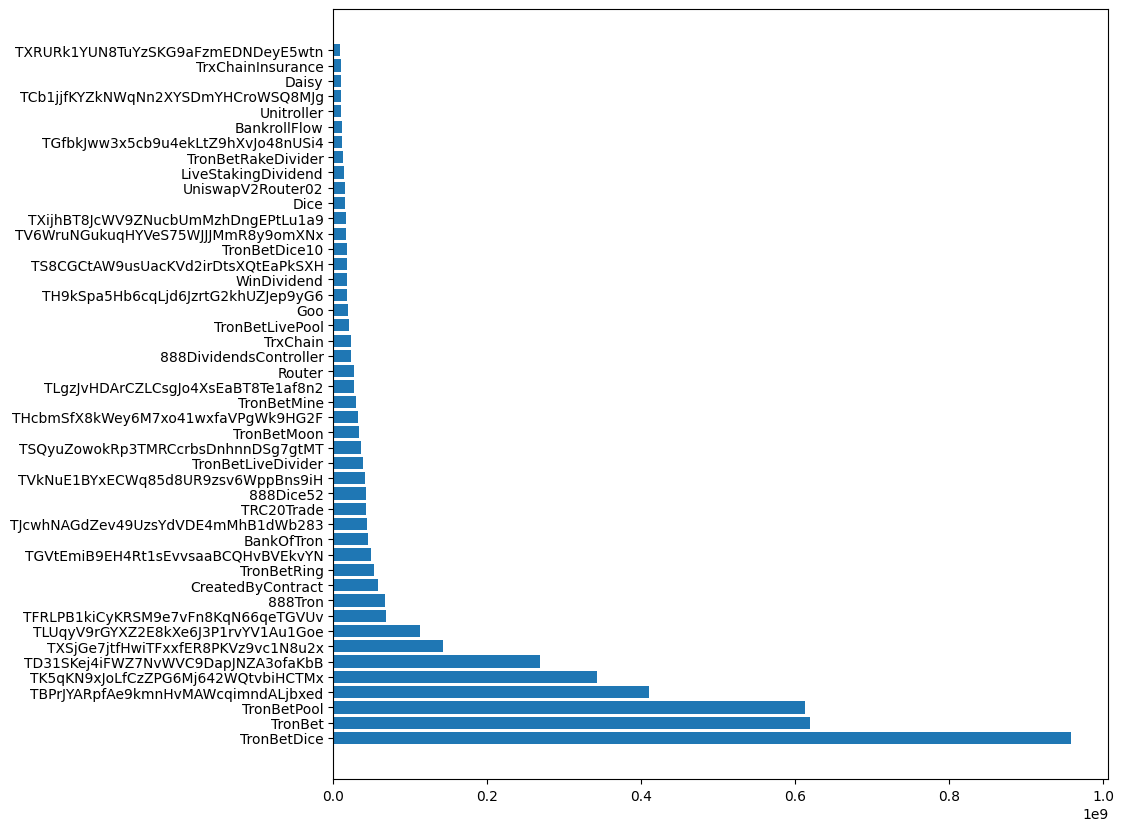

In [4]:
q = client.query(f'SELECT callerAddress, count(*) as cnt from tron.internals group by callerAddress order by cnt desc limit 50')
result = list(q.named_results())

data = []
labels = []
for i, r in enumerate(result):
    name = r["callerAddress"].decode()
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(name)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )


no name found for TRvzE7AjfD9e73uVKfkGWEsNZemz5tz5Vw
no name found for TD31SKej4iFWZ7NvWVC9DapJNZA3ofaKbB
no name found for TBPrJYARpfAe9kmnHvMAWcqimndALjbxed
no name found for TLUqyV9rGYXZ2E8kXe6J3P1rvYV1Au1Goe
no name found for TBHN6guS6ztVVXbFivajdG3PxFUZ5UXGxY
no name found for THcbmSfX8kWey6M7xo41wxfaVPgWk9HG2F
no name found for TFRLPB1kiCyKRSM9e7vFn8KqN66qeTGVUv
no name found for TJcwhNAGdZev49UzsYdVDE4mMhB1dWb283
no name found for TLgzJvHDArCZLCsgJo4XsEaBT8Te1af8n2
no name found for TM93hptEqh8wBsnzJfYvUnuy6WPHSb6Z9x
no name found for TLENBrPKTzcYw9M9YPsfzWS1vf7fmgmr6W
no name found for TRi5fEYrPVK5kczmShn38L345kcREZg83m
no name found for TAPX34wUQa6TBgSzj2dBJbjhKpUhejwnaP
no name found for TH9kSpa5Hb6cqLjd6JzrtG2khUZJep9yG6


<BarContainer object of 50 artists>

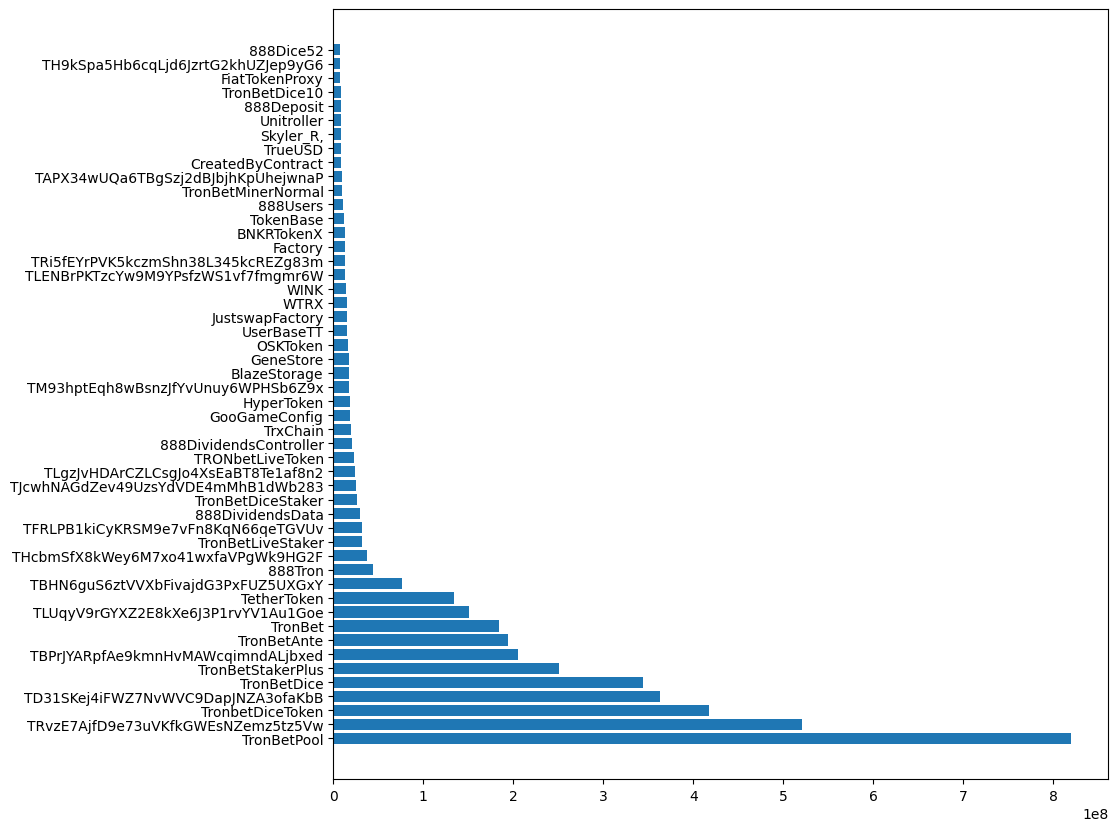

In [5]:
q = client.query(f'SELECT transferToAddress, count(*) as cnt from tron.internals group by transferToAddress order by cnt desc limit 50')
result = list(q.named_results())

data = []
labels = []
for i, r in enumerate(result):
    name = r["transferToAddress"].decode()
    data.append(r["cnt"])
    labels.append(f"{get_contract_name(name)}")

plt.figure(figsize=(10,10)) # Set figure size
plt.barh(labels, data, )